# Preparing to start

In [325]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt
from sklearn import cluster, metrics
from scipy.cluster.hierarchy import dendrogram
import scipy.spatial.distance as distance


Random seed:

In [326]:
SEED = 2216929
RS = numpy.random.RandomState(numpy.random.MT19937(numpy.random.SeedSequence(SEED)))

Useful functions:

In [327]:
def get_all_pairs(up):
    all_pairs = []
    for i in range(up):
        all_pairs.extend([(i, j) for j in range(i+1, up)])
    return all_pairs


def relabel_clusters_size(cluster_labels):
    counts = numpy.bincount(cluster_labels+1)
    count_outliers = counts[0]
    count_clust = counts[1:]
    relabel_map = -numpy.ones(len(counts), dtype=int)
    relabel_map[numpy.argsort(-count_clust)] = numpy.arange(len(count_clust), dtype=int)
    return relabel_map[cluster_labels], relabel_map

clust_colors_def = numpy.array(["#1965B0", "#4EB265", "#F7F056", "#DC050C", "#7BAFDE", 
                                "#CAE0AB", "#882E72", "#EE8026", "#72190E", 
                                "#888888"])


def plot_data_vpair(ax, data, vpair, vnames, clabels=None, ccenters=None, map_clabels=None, clust_colors=None):
    if clust_colors is None:
       clust_colors = clust_colors_def
    ax.set_xlabel(vnames[vpair[0]])
    ax.set_ylabel(vnames[vpair[1]])
    if clabels is not None:
        ax.scatter(data[:,vpair[0]], data[:,vpair[1]], c=clust_colors[clabels], edgecolors="none", alpha=0.8)
    else:
        ax.scatter(data[:,vpair[0]], data[:,vpair[1]], c=clust_colors[-1], edgecolors="none", alpha=0.8)
    if ccenters is not None:
        ax.scatter(ccenters[:,vpair[0]], ccenters[:,vpair[1]], s=100, c=clust_colors[map_clabels[:-1]], marker="+")
    

def plot_data(data, vnames, vpairs, clabels=None, ccenters=None, map_clabels=None, clust_colors=None):
    if clust_colors is None:
       clust_colors = clust_colors_def
    natt_cols = 3
    natt_rows = int(numpy.ceil(len(vpairs)/natt_cols))
    figsize=(15, 4*natt_rows)

    fig, axg = plt.subplots(natt_rows, natt_cols, figsize=figsize)
    axes = axg.flatten()
    for i, (xi, yi) in enumerate(vpairs):
        plot_data_vpair(axes[i], data, (xi, yi), vnames, clabels, ccenters, map_clabels, clust_colors)
        
    plt.tight_layout()


def make_contingency_matrix(labelsA, labelsB):
    ulblA = numpy.unique(labelsA)
    ulblB = numpy.unique(labelsB)
    C = numpy.zeros((len(ulblA), len(ulblB)), dtype=int)
    for lA, lB in zip(labelsA, labelsB):
        C[lA, lB] += 1
    return C, ulblA, ulblB


def plot_contingency_matrix(clabelsA, clabelsB, name_rows, name_columns, data=None, vnames=None, vpair=None, clust_colors=None):
    if clust_colors is None:
       clust_colors = clust_colors_def
    
    if not any([x is None for x in [data, vnames, vpair]]):
        with_sc = True
        fig, axg = plt.subplots(1, 3, figsize=(15,5))
        ax = axg[1]
    else:
        with_sc = False
        fig, axg = plt.subplots()
        ax = axg
    
    C, ulblA, ulblB = make_contingency_matrix(clabelsA, clabelsB)
    paddedC = numpy.zeros((C.shape[0]+2, C.shape[1]+2), dtype=int)
    paddedC[1:-1, 1:-1] = C
    marginR = numpy.sum(C, axis=1)
    marginC = numpy.sum(C, axis=0)
    vmax = numpy.maximum(numpy.max(marginC), numpy.max(marginR))

        
    im = ax.imshow(paddedC, cmap='binary', vmax = vmax)
    
    # Loop over data dimensions and create text annotations.
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            if C[i, j] > 0.5*vmax:
                text = ax.text(j+1, i+1, C[i, j], ha="center", va="center", color="w")
            elif C[i, j] > 0:
                text = ax.text(j+1, i+1, C[i, j], ha="center", va="center", color="k")


    for i in ulblA:
        ci = i+1
        if i == -1: # outliers -> last column
            ci = len(ulblA)
        text = ax.text(0, ci, "A%d" % i, ha="center", va="center", color="w", backgroundcolor=clust_colors[i], fontweight="bold")
        text = ax.text(len(ulblB)+1, ci, marginR[i], ha="center", va="center", color=clust_colors[i])

        
    for j in ulblB:
        rj = j+1
        if j == -1: # outliers -> last row
            rj = len(ulblB)
        text = ax.text(rj, 0, "B%d" % j, ha="center", va="center", color="w", backgroundcolor=clust_colors[j], fontweight="bold")
        text = ax.text(rj, len(ulblA)+1, marginC[j], ha="center", va="center", color=clust_colors[j])

    ax.set_xlabel(name_columns)
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(name_rows)
    ax.yaxis.set_tick_params(left = False, right = False, labelleft = False)
    ax.xaxis.set_tick_params(top = False, bottom = False, labelbottom = False)
    ax.set_title("Contingency matrix")
    
    if with_sc:
        plot_data_vpair(axg[0], data, vpair, vnames, clabels=clabelsA, clust_colors=clust_colors)
        axg[0].set_title(name_rows)
        plot_data_vpair(axg[2], data, vpair, vnames, clabels=clabelsB, clust_colors=clust_colors)
        axg[2].set_title(name_columns)
     
    plt.tight_layout() 


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    if "link_color_func" not in kwargs:
        kwargs["link_color_func"] = lambda k: "#888888"
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


def intra_inter_distance_ratio(v_dist, clabels):
    Ct = numpy.tile(clabels, (len(clabels), 1))
    v_sameclass = distance.squareform((Ct == Ct.T) & (Ct != -1), checks=False)
    v_diffclass = distance.squareform((Ct != Ct.T) & (Ct != -1) & ( -1 != Ct.T), checks=False)
    return numpy.mean(v_dist[v_sameclass])/numpy.mean(v_dist[v_diffclass])
    

# Loading and preparing the data

We'll be analysing the `Wholesale customers Data Set`. The different categories are for the annual spending on different kinds of products, and two categories for customer channel and region. From the dataset description page:

1) FRESH: annual spending (m.u.) on fresh products (Continuous);
2) MILK: annual spending (m.u.) on milk products (Continuous);
3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
4) FROZEN: annual spending (m.u.)on frozen products (Continuous);
5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous);
6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous).
7) CHANNEL: customer Channel - Horeca (Hotel/Restaurant/Café) or Retail channel (Nominal)
8) REGION: customer Region - Lisnon, Oporto or Other (Nominal)

The dataset also provides descriptive statistics about the categories:

Category (Minimum, Maximum, Mean, Std. Deviation)

- FRESH (3, 112151, 12000.30, 12647.329)
- MILK (55, 73498, 5796.27, 7380.377)
- GROCERY (3, 92780, 7951.28, 9503.163)
- FROZEN (25, 60869, 3071.93, 4854.673)
- DETERGENTS_PAPER (3, 40827, 2881.49, 4767.854)
- DELICATESSEN (3, 47943, 1524.87, 2820.106)
- REGION Frequency:
   - Lisbon 77
   - Oporto 47
   - Other Region 316
   - Total 440
- CHANNEL Frequency
   - Horeca 298
   - Retail 142
   - Total 440

For the evaluation section, the `CHANNEL` category will be used.

More details can be found in the following link: https://archive.ics.uci.edu/ml/datasets/wholesale+customers#

In [328]:
dtf = pandas.read_csv("wholesale.csv", header=0)
dtf

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


Getting a smaller variant of the dataset:

In [329]:
Xorg = dtf.values[:,2:].astype(float)

Let's focus on the continuous categories: we'll ignore channel and region.

In [330]:
cnames = dtf.columns[2:]
var_map = dict([(vn, vi) for (vi, vn) in enumerate(cnames)])
vnames6v = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

We'll plot 9 pairs of variables.

In [331]:
vps = dict([(pname, (vnames6v.index(vA), vnames6v.index(vB)))
                for (pname, vA, vB) in 
                [("Fresh-Milk", 'Fresh', 'Milk'), 
                 ("Groc-DetPap", 'Grocery', 'Detergents_Paper')]])
vpairs6v = get_all_pairs(4)
vpairs6v.extend([(vnames6v.index(vA), vnames6v.index(vB)) for (vA, vB) in 
                [('Fresh', 'Milk'), ('Grocery', 'Detergents_Paper'), ('Frozen', 'Delicassen')]])
vpairs6v

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (0, 1), (2, 4), (3, 5)]

Extract the desired subset from the dataset:

In [332]:
X = Xorg[:,[var_map[v] for v in vnames6v]]
X.shape

(440, 6)

Plotting the scatterplots of the pairs of variable, we obtain the following:

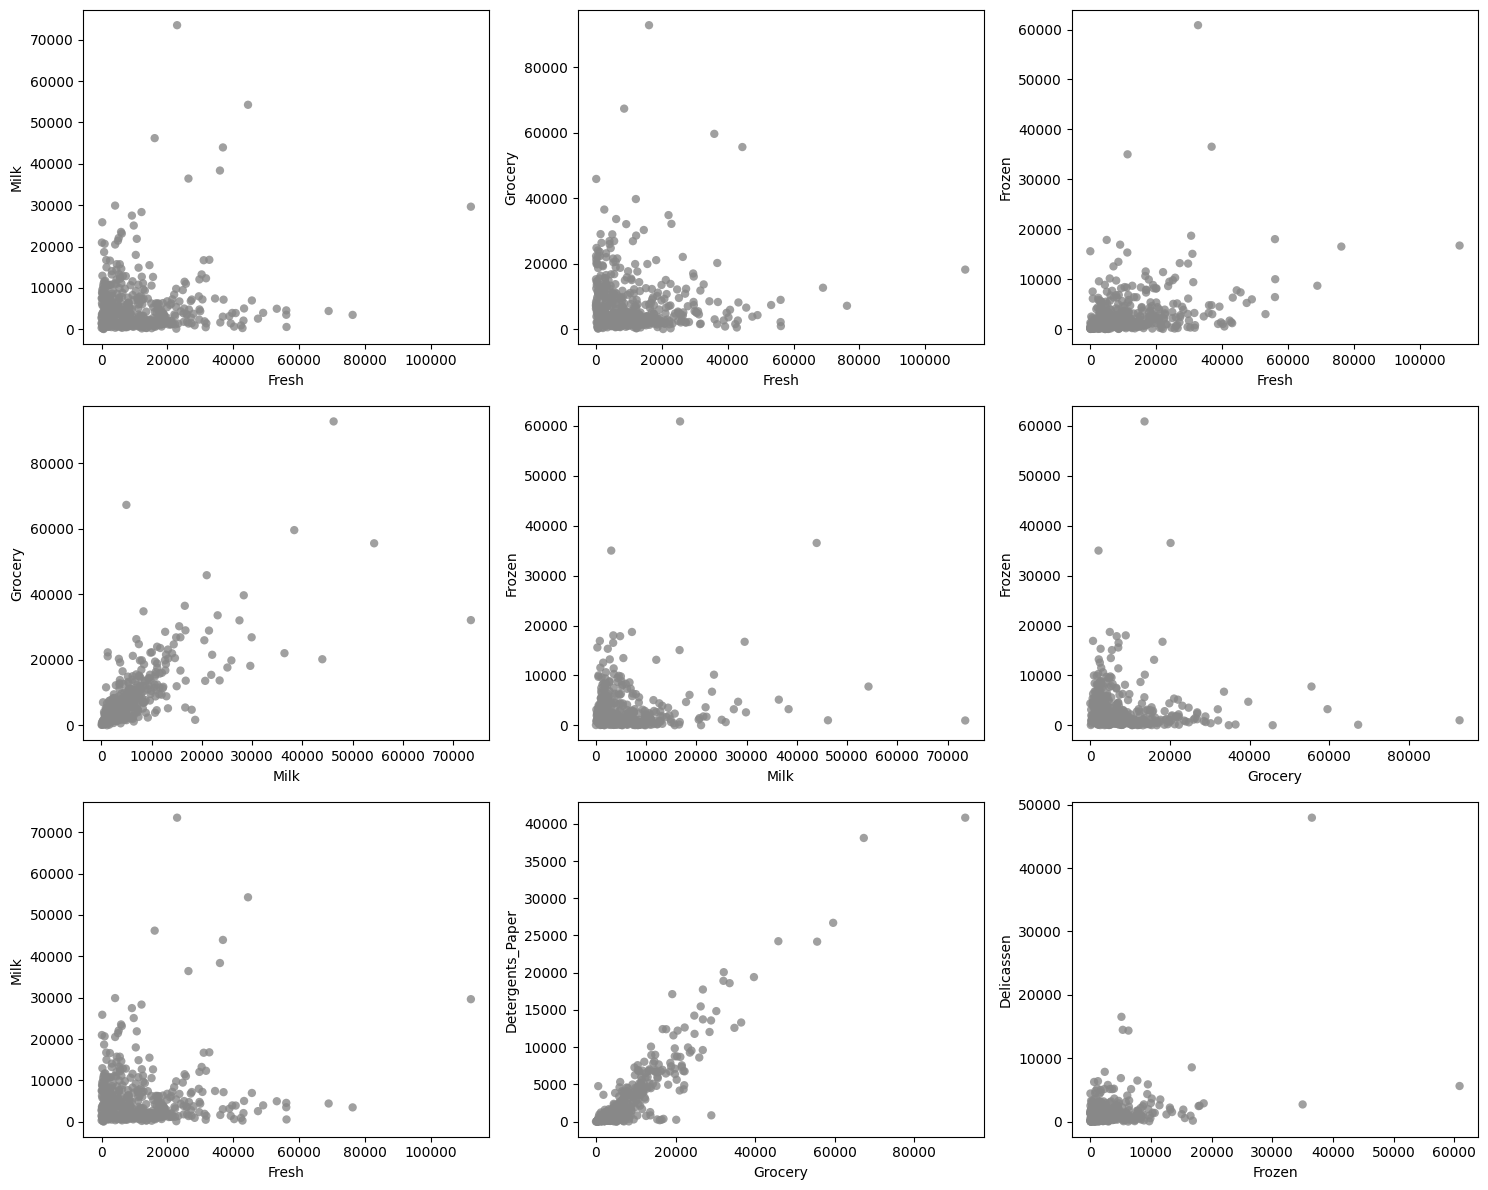

In [333]:
plot_data(X, vnames6v, vpairs6v)

Before clustering the data, let's normalize the dataset.

In [334]:
Xn6v = numpy.vstack([(X[:,i]-numpy.min(X[:,i]))/(numpy.max(X[:,i])-numpy.min(X[:,i])) for i in range(X.shape[1])]).T

And plot it.

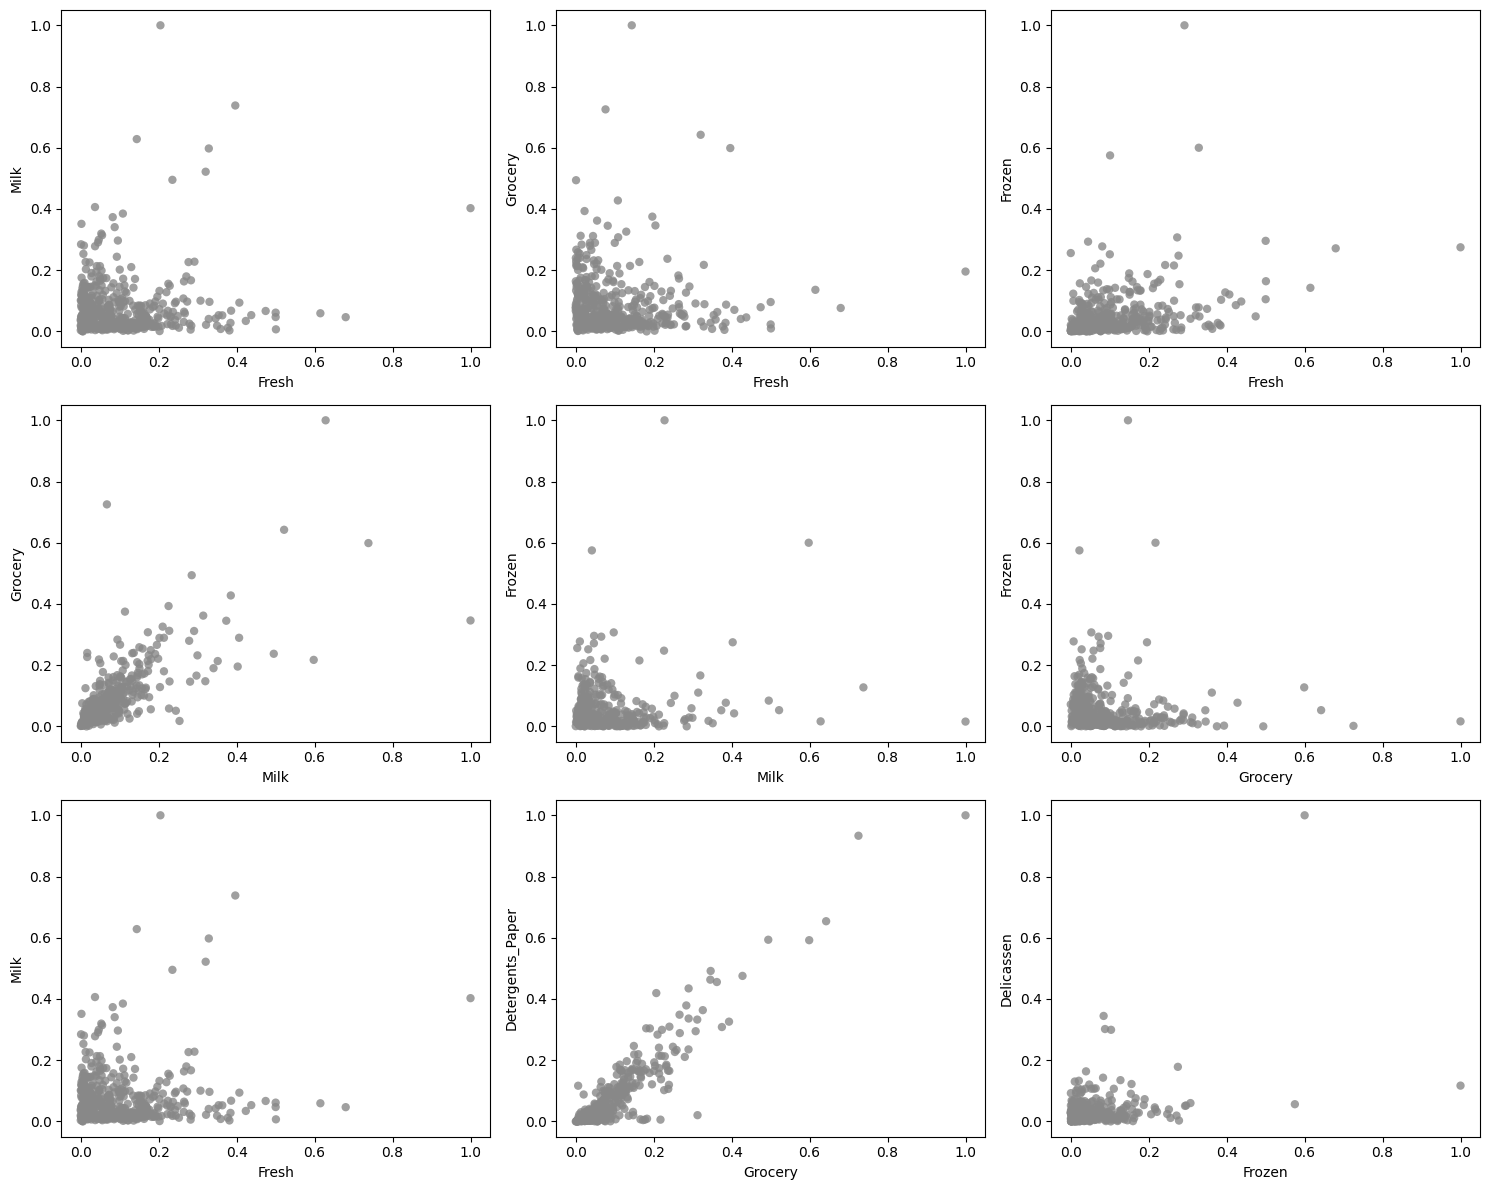

In [335]:
plot_data(Xn6v, vnames6v, vpairs6v)

# Clustering

Let's cluster the data using the different available algorithms, starting with $k$-means.

## $k$-means

Let's start with 4 clusters.

In [336]:
clKMn6v4 = cluster.KMeans(n_clusters=4, random_state=RS).fit(Xn6v)
clKMn6v4_labels, map_labels = relabel_clusters_size(clKMn6v4.labels_)

Plotting the $k$-means clustering, we obtain the following:

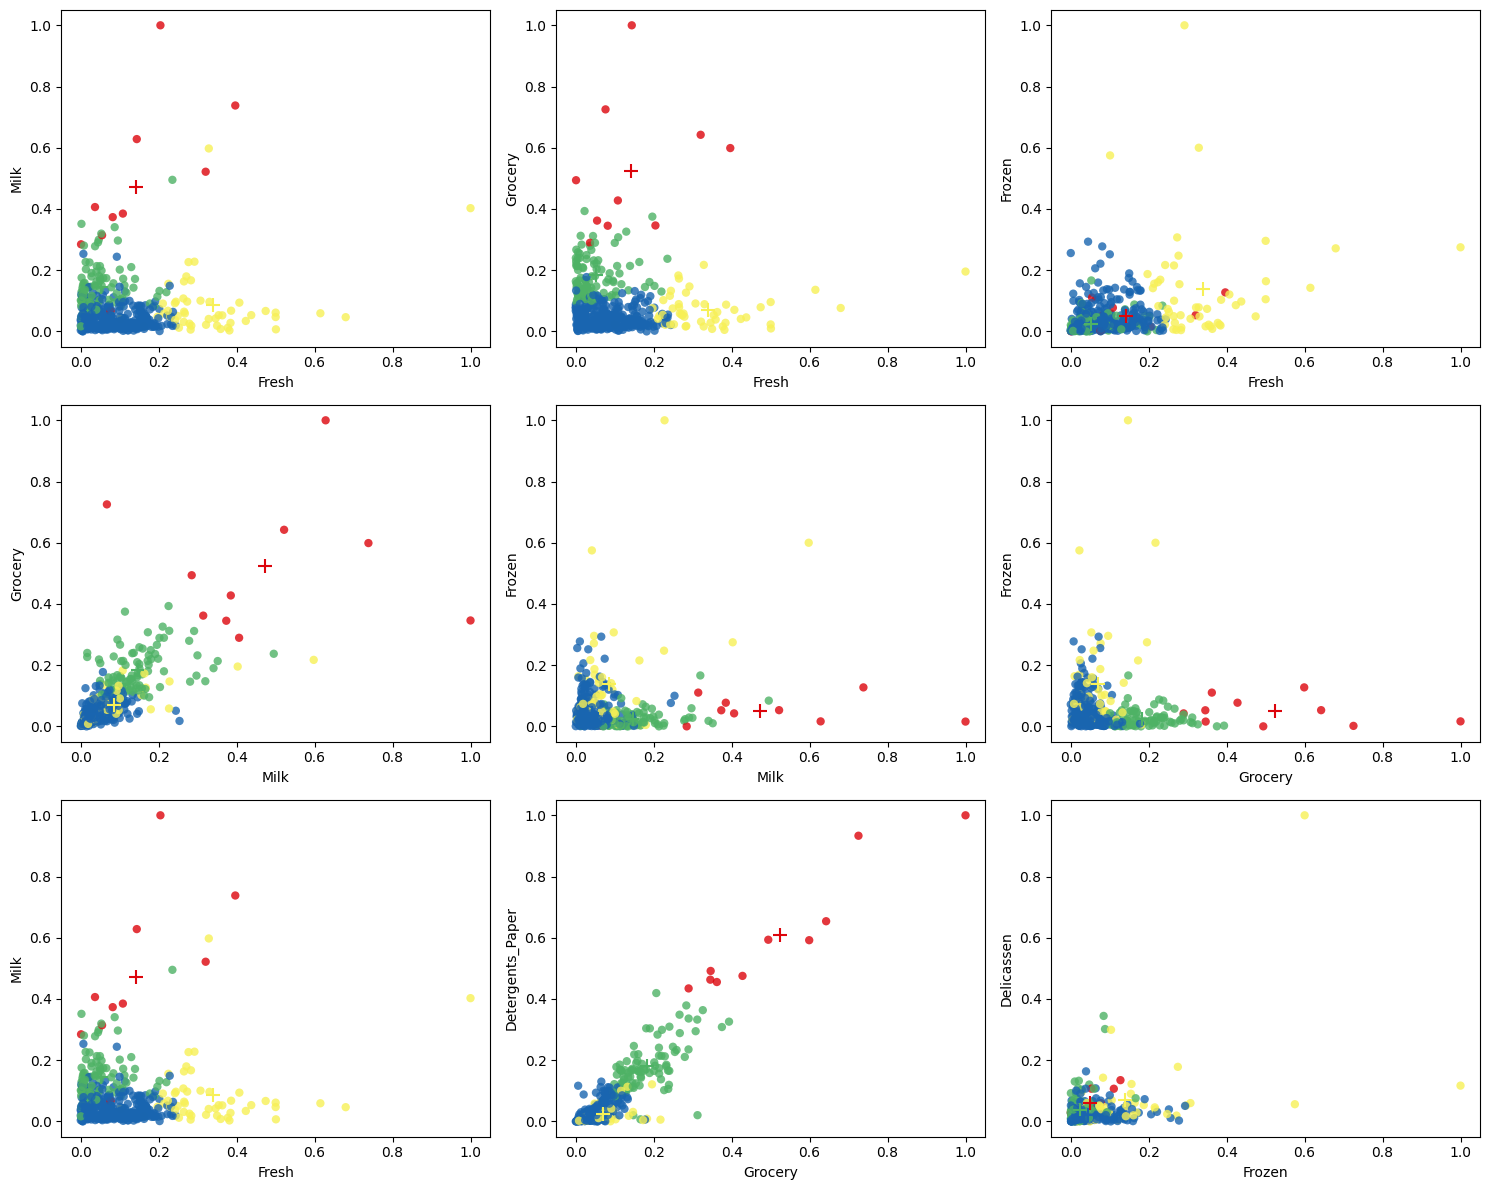

In [337]:
plot_data(Xn6v, vnames6v, vpairs6v, clKMn6v4_labels, clKMn6v4.cluster_centers_, map_labels)

Let's check what changes when we cluster the data before normalizing it. For that, we'll compare the contigency matrix of the normalized and unscaled datasets.

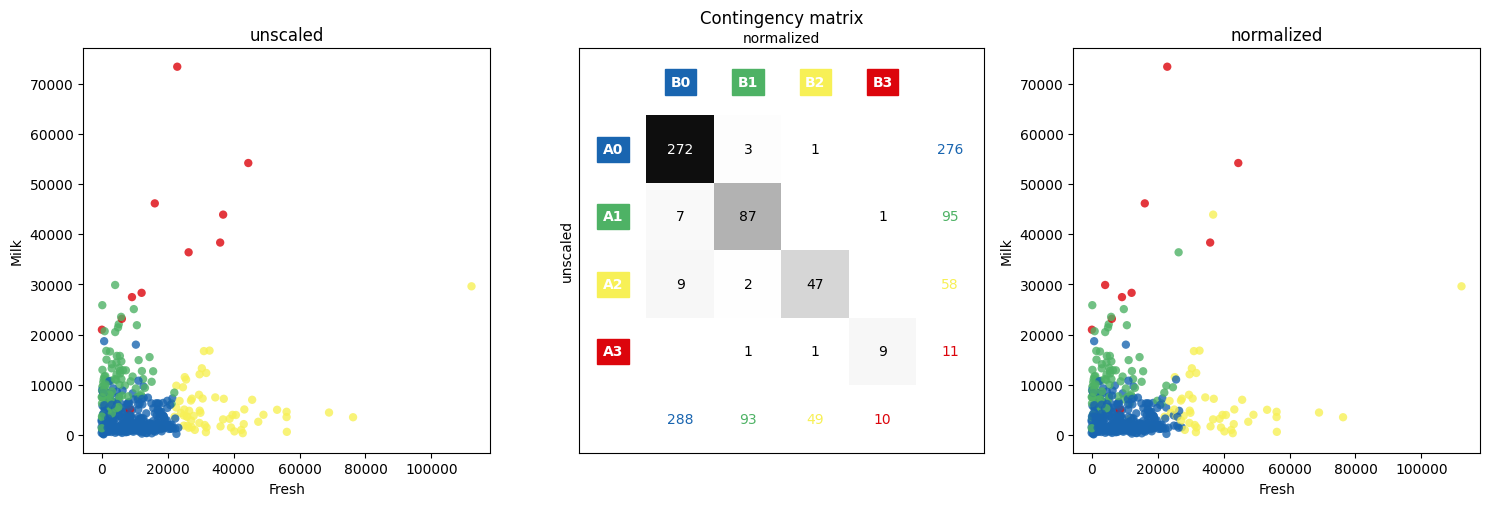

In [338]:
clKM = cluster.KMeans(n_clusters=4, random_state=RS).fit(X)
clKM_labels, map_labels = relabel_clusters_size(clKM.labels_)

plot_contingency_matrix(clKM_labels, clKMn6v4_labels, "unscaled", "normalized", X, vnames6v, vps["Fresh-Milk"]) 

In the case of the clustering for `Fresh-Milk`, we don't see much difference in the clusterings, likely due to the datapoints being grouped together in the corner. What if we check the clustering for a more linearly spread pair, such as `Groc-DetPap` (Grocery and Detergent-Paper)?

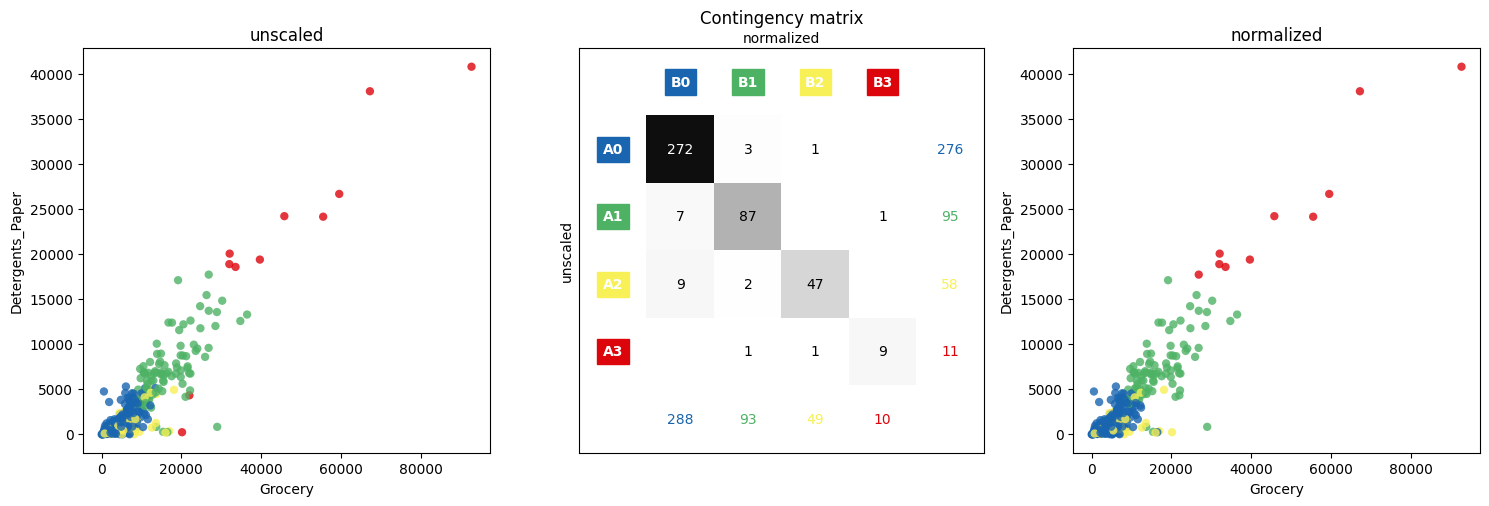

In [339]:
plot_contingency_matrix(clKM_labels, clKMn6v4_labels, "unscaled", "normalized", X, vnames6v, vps["Groc-DetPap"]) 

Most differences are in the grouped datapoints in the lower-left corner. In this dataset, we don't see much difference between the clusterings in an unscaled and normalized format. Nonetheless, we'll progress the analysis with the normalized dataset.

For an additional inspection, we can check the rand score both cases. We avoid NMIS this time around since it requires the dataset to be normalized.

In [340]:
metrics.rand_score(clKMn6v4_labels, clKM_labels)

0.9233795816939325

For comparison, the `Beans` dataset unscaled vs normalized clusterings resulted in a rand score of `0.7790`, which makes sense since in that case, the unscaled clustering was very different from the normalized clustering.

Moving on, we analyse the normalized dataset with 8 clusters.

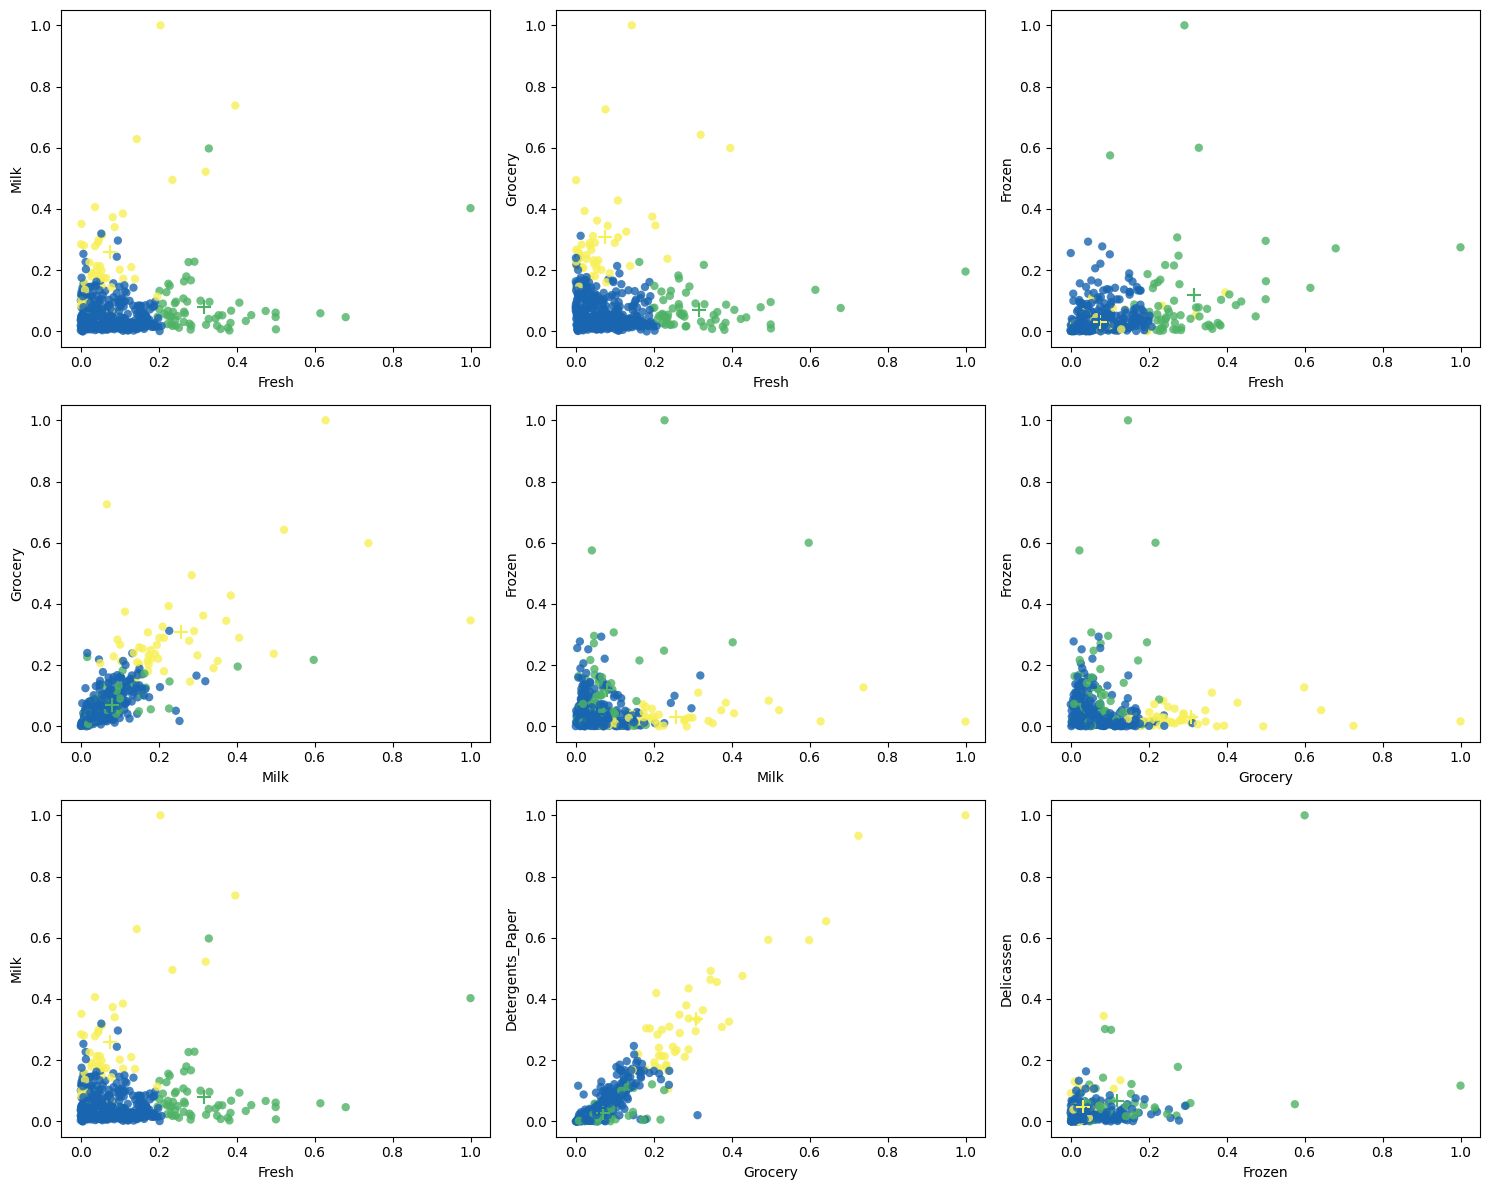

In [341]:
clKMn6v8 = cluster.KMeans(n_clusters=3, random_state=RS).fit(Xn6v)
clKMn6v8_labels, map_labels = relabel_clusters_size(clKMn6v8.labels_)

plot_data(Xn6v, vnames6v, vpairs6v, clKMn6v8_labels, clKMn6v8.cluster_centers_, map_labels)

And we compare the clusterings obtained for $k=4$ and $k=3$, respectively.

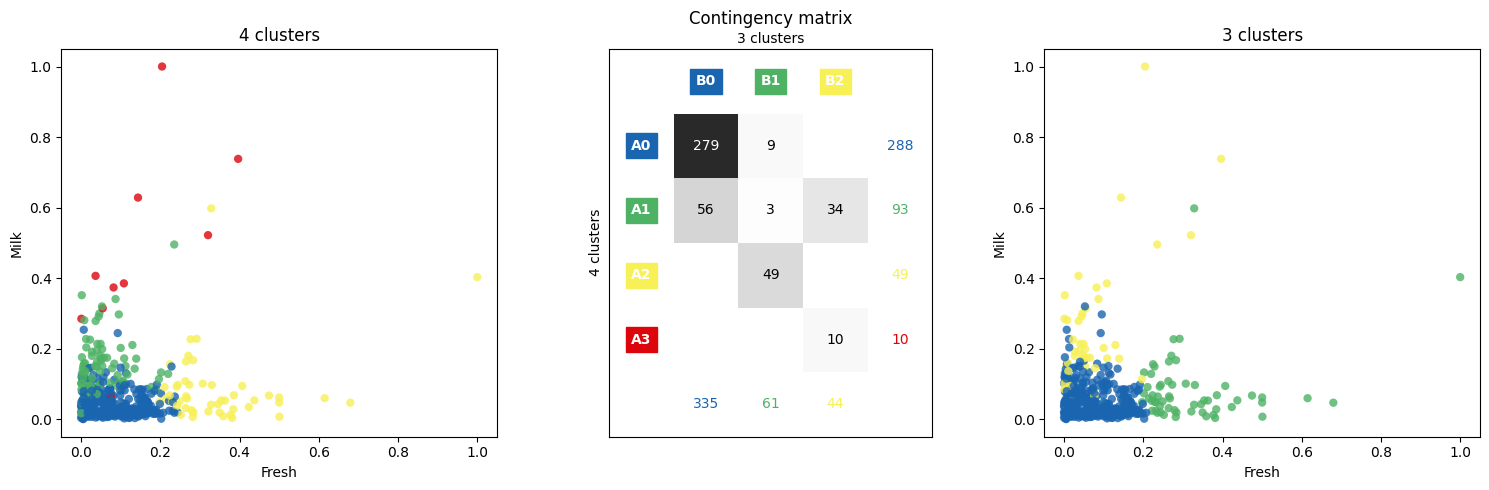

In [342]:
plot_contingency_matrix(clKMn6v4_labels, clKMn6v8_labels, "4 clusters", "3 clusters", Xn6v, vnames6v, vps["Fresh-Milk"])

The two clusterings largely agree in the `A0` and `B0` clusters, as well as `A2` and `B1`. We can also check the rand score and NMI:

In [343]:
metrics.rand_score(clKMn6v4_labels, clKMn6v8_labels), metrics.normalized_mutual_info_score(clKMn6v4_labels, clKMn6v8_labels)

(0.7798301925864568, 0.5521733170167695)

The rand score is high, but NMI is average. As the datapoints are mostly grouped together in a small area of the plots, the clusterings diverge more.

Analysing the different results between the other methods and $k$-means will be more interesting than analysing the difference between 3 and 4 clusters $k$-means.

## Bisecting $k$-means

Now for the clustering with bisecting $k$-means algorithm.

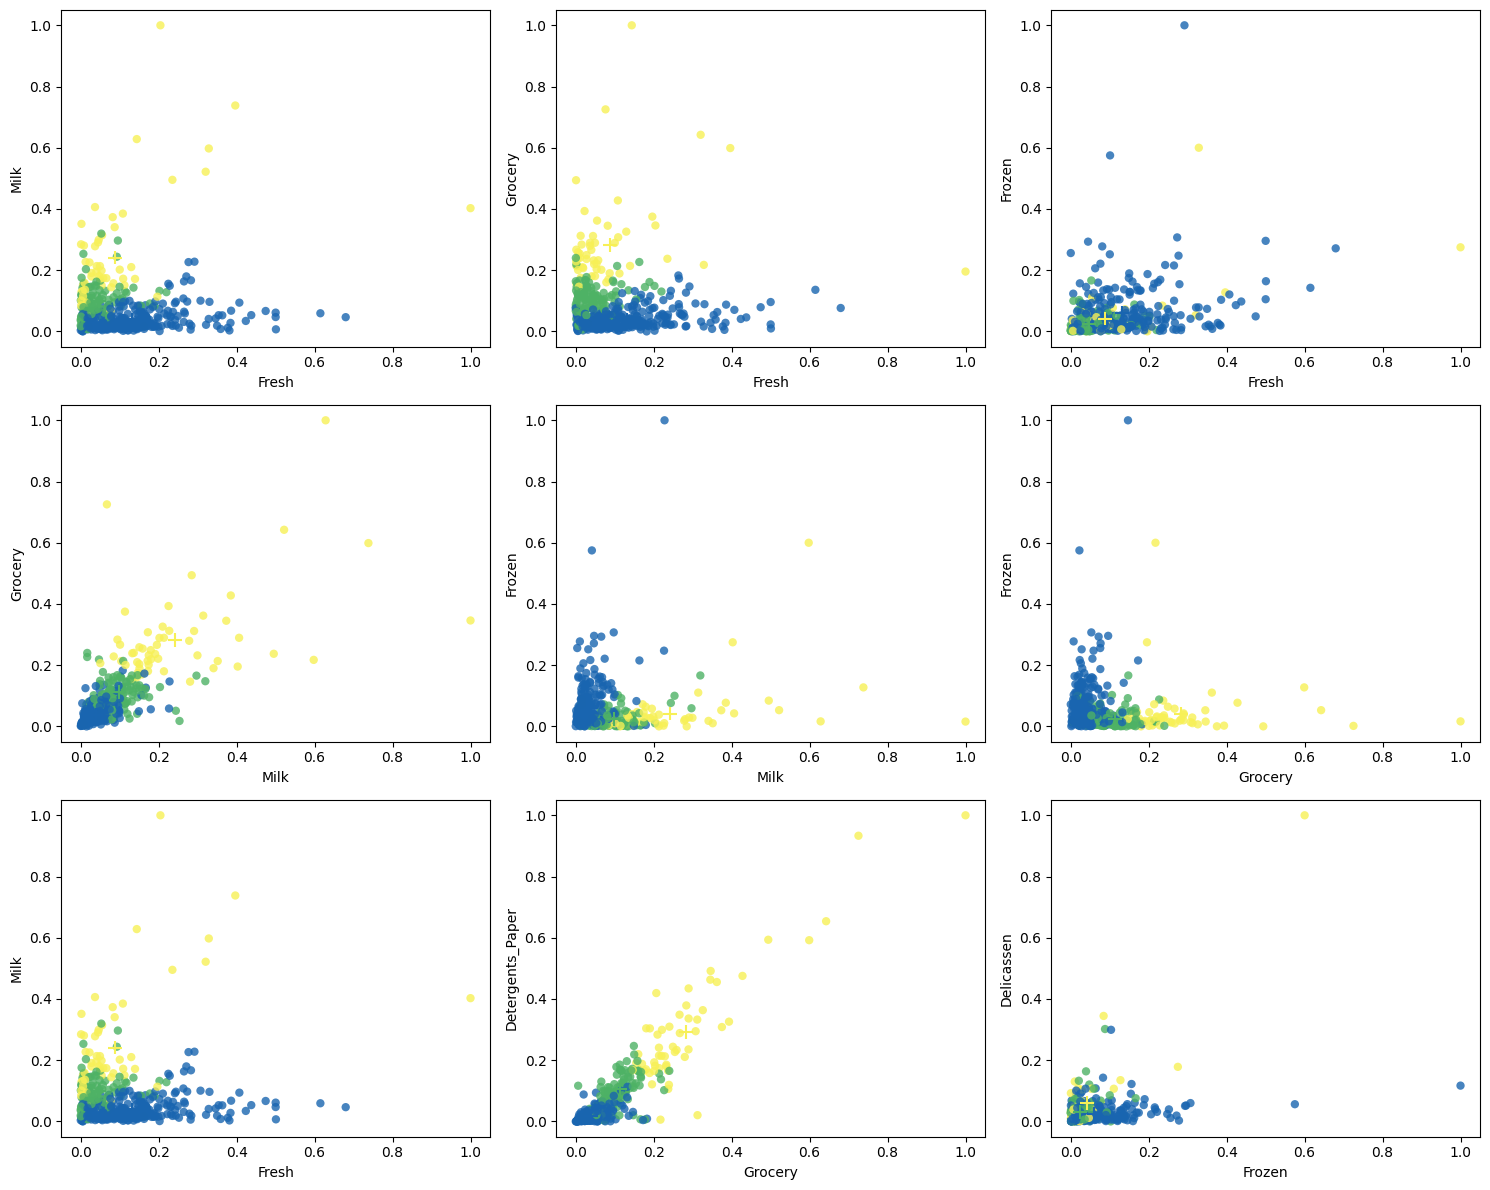

In [344]:
clBKMn6v8 = cluster.BisectingKMeans(n_clusters=3, random_state=RS).fit(Xn6v)
clBKMn6v8_labels, map_labels = relabel_clusters_size(clBKMn6v8.labels_)

plot_data(Xn6v, vnames6v, vpairs6v, clBKMn6v8_labels, clBKMn6v8.cluster_centers_, map_labels)

Next, we compare the clusterings of $k$-means with bisecting $k$-means.

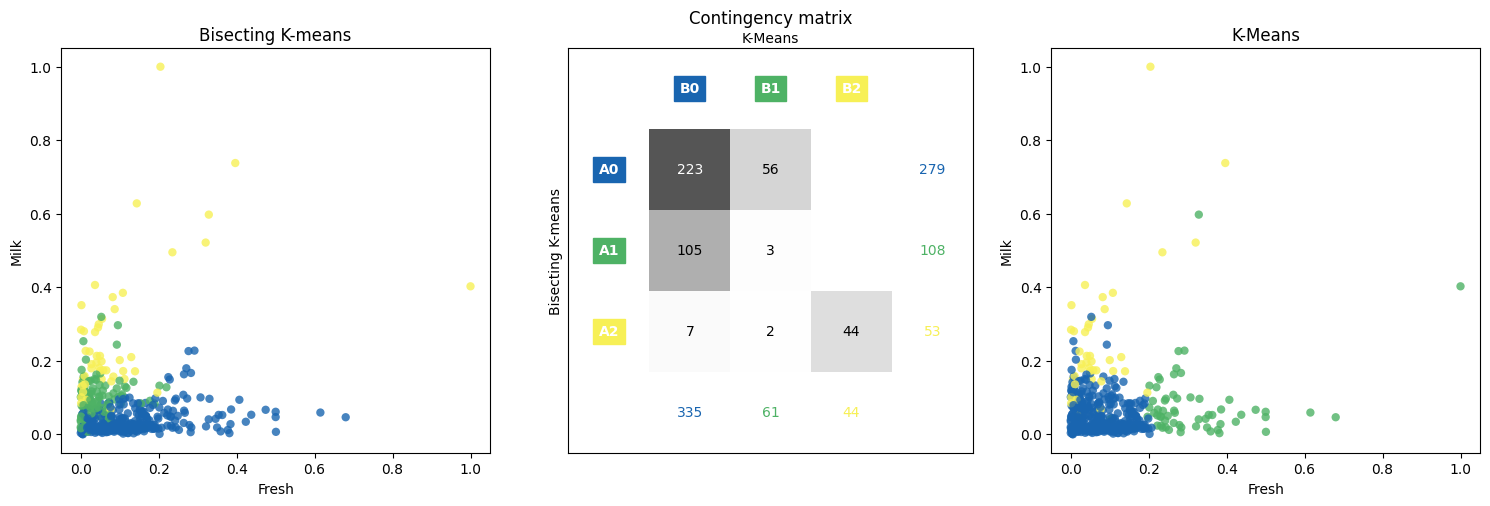

In [345]:
plot_contingency_matrix(clBKMn6v8_labels, clKMn6v8_labels, "Bisecting K-means", "K-Means", Xn6v, vnames6v, vps["Fresh-Milk"])

Here, it's noticeable how clusters `A0`, `B0` and `B1` overlap, and `B0` with `A0` and `A1`.

For the rand score and NMIS:

In [346]:
metrics.rand_score(clBKMn6v8_labels, clKMn6v8_labels), metrics.normalized_mutual_info_score(clBKMn6v8_labels, clKMn6v8_labels)

(0.5940153240836612, 0.37113461468499276)

The results are surprisingly low for NMIS. Rand score is average. This is most likely due to how `A0` gets split into different clusters, causing disagreement between the two methods.

## Agglomerative methods

For agglomerative methods, we'll analyse clustering with _complete linkage_, _single linkage_, _average linkage_ and _ward linkage_.

### Complete linkage

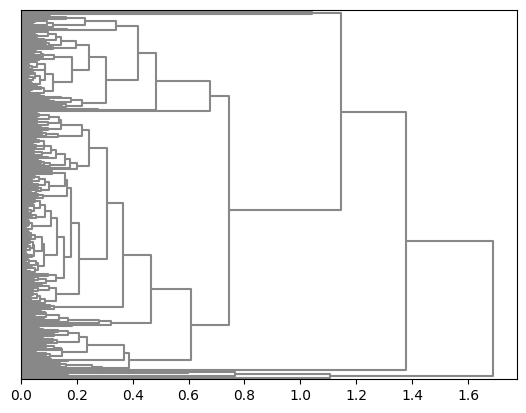

In [347]:
model = cluster.AgglomerativeClustering(linkage="complete", distance_threshold=0, n_clusters=None).fit(Xn6v)
plot_dendrogram(model, orientation='right', truncate_mode="level", p=100, no_labels=True)

Zooming into the last 3 clusters:

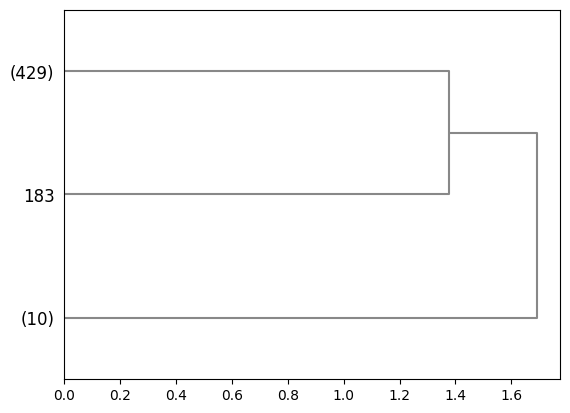

In [348]:
plot_dendrogram(model, orientation='right', truncate_mode="lastp", p=3)

Which corresponds to clustering with $k=3$.

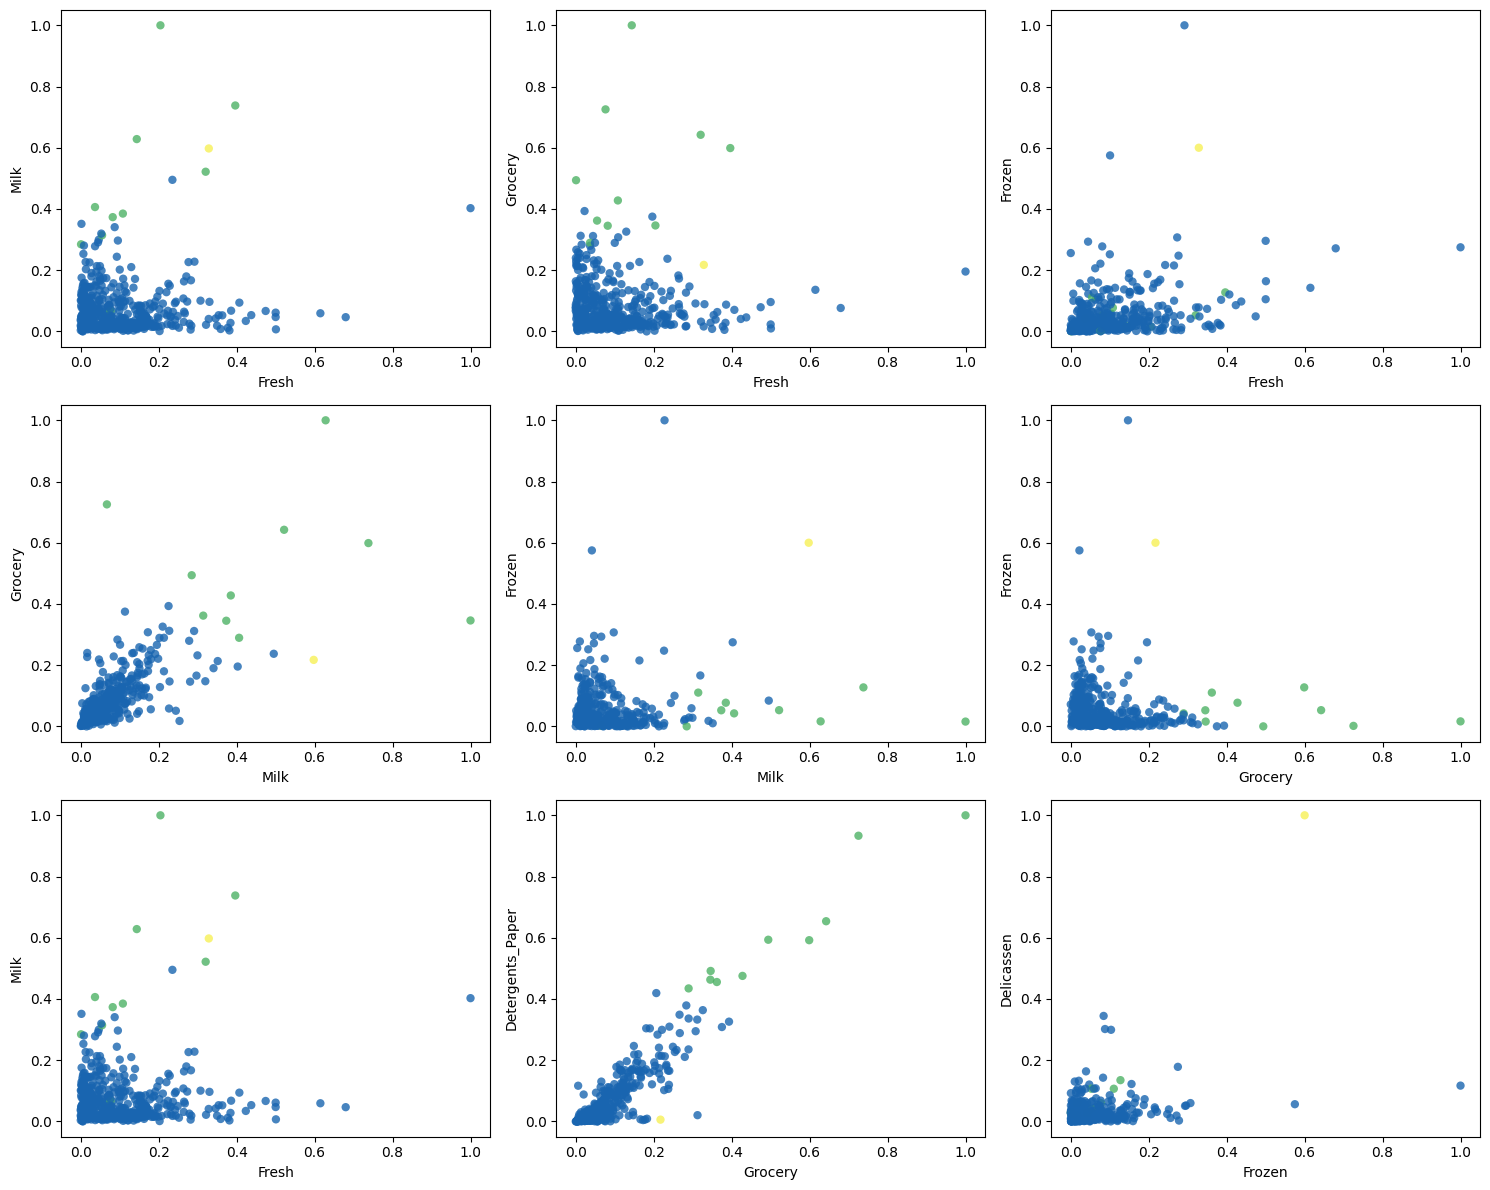

In [349]:
clACn6v8 = cluster.AgglomerativeClustering(linkage="complete", n_clusters=3).fit(Xn6v)
clACn6v8_labels, map_labels = relabel_clusters_size(clACn6v8.labels_)

plot_data(Xn6v, vnames6v, vpairs6v, clACn6v8_labels)

Comparing with the result from $k$-means:

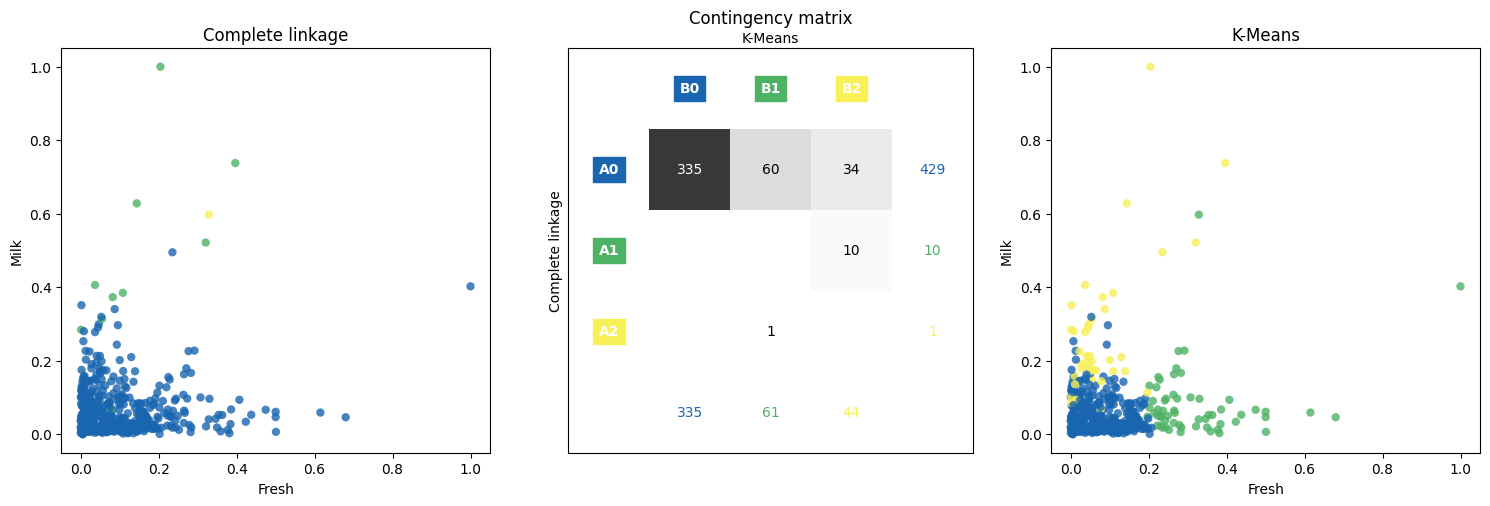

In [350]:
plot_contingency_matrix(clACn6v8_labels, clKMn6v8_labels, "Complete linkage", "K-Means", Xn6v, vnames6v, vps["Fresh-Milk"])

It's clear the _complete linkage_ clustered most datapoints into the `A0` cluster. This is likely to have an effect in the rand and NMIS scores:

In [351]:
metrics.rand_score(clACn6v8_labels, clKMn6v8_labels), metrics.normalized_mutual_info_score(clACn6v8_labels, clKMn6v8_labels)

(0.6486850279560986, 0.141887535130172)

We can see that although rand score is average, NMIS is very below average.

### Single linkage

Next, we apply the _single linkage_ algorithm.

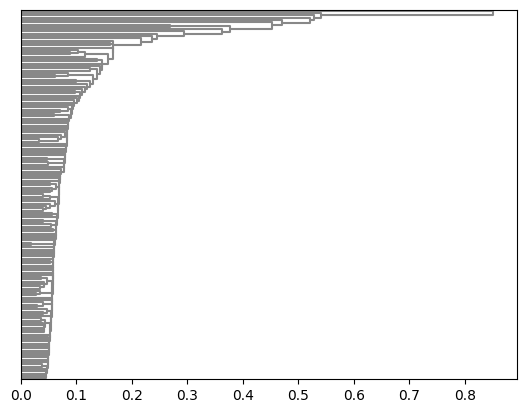

In [352]:
model = cluster.AgglomerativeClustering(linkage="single", distance_threshold=0, n_clusters=None).fit(Xn6v)
plot_dendrogram(model, orientation='right', truncate_mode="level", p=100, no_labels=True)

For the last 3 clusters:

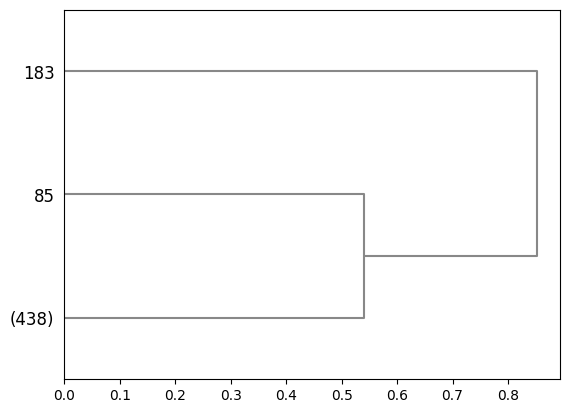

In [353]:
plot_dendrogram(model, orientation='right', truncate_mode="lastp", p=3)

Plotting the clusters, we obtain:

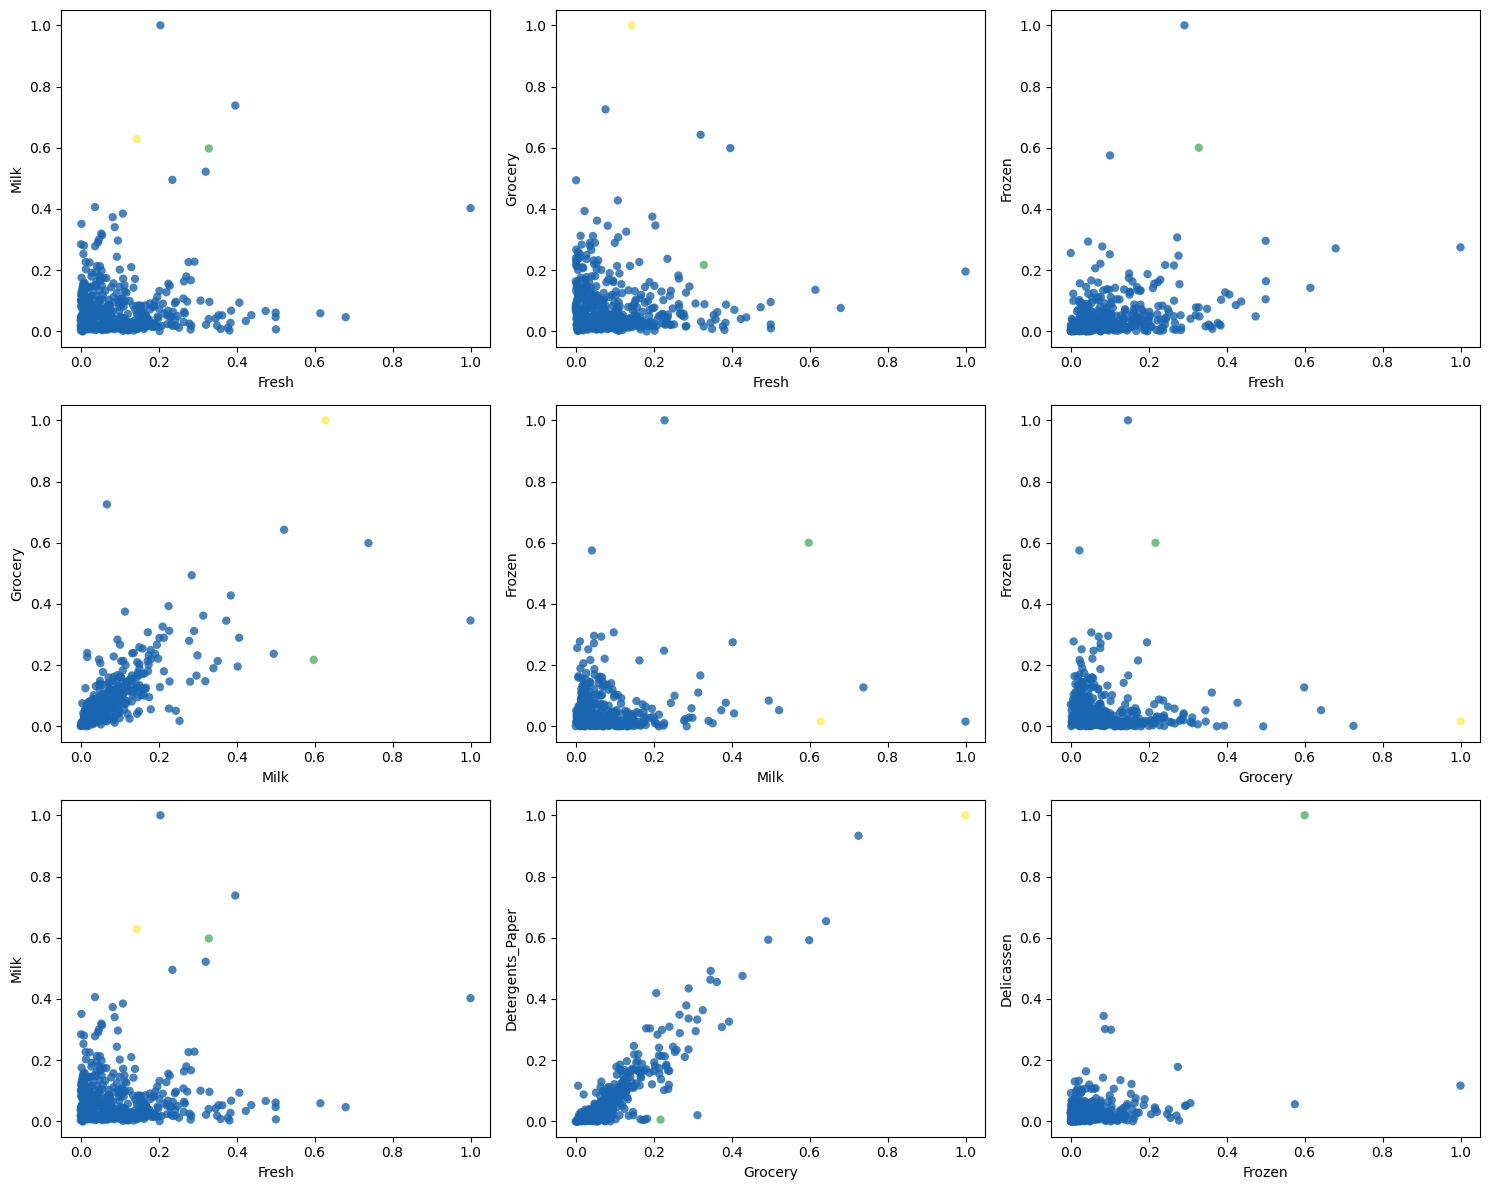

In [354]:
clASn6v8 = cluster.AgglomerativeClustering(linkage="single", n_clusters=3).fit(Xn6v)
clASn6v8_labels, map_labels = relabel_clusters_size(clASn6v8.labels_)

plot_data(Xn6v, vnames6v, vpairs6v, clASn6v8_labels)

Once again, most of the datapoints are in a single cluster. Let's check the contingency matrix comparing it with $k$-means.

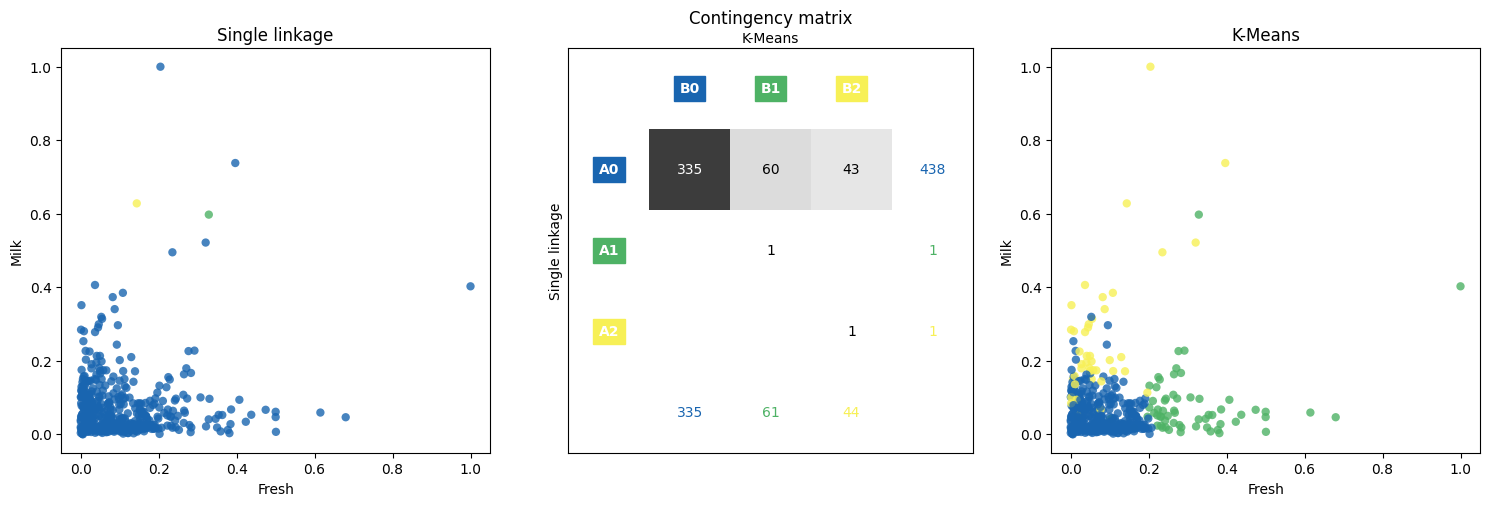

In [355]:
plot_contingency_matrix(clASn6v8_labels, clKMn6v8_labels, "Single linkage", "K-Means", Xn6v, vnames6v, vps["Fresh-Milk"])

As expected, most datapoints are in cluster `A0`. As for the rand and NMIS scores:

In [356]:
metrics.rand_score(clASn6v8_labels, clKMn6v8_labels), metrics.normalized_mutual_info_score(clASn6v8_labels, clKMn6v8_labels)

(0.614951335680265, 0.026232753219260763)

Once again, as expected, the agreement is very low, with `NMIS = 0.026`!

### Average linkage

Now for _average linkage_:

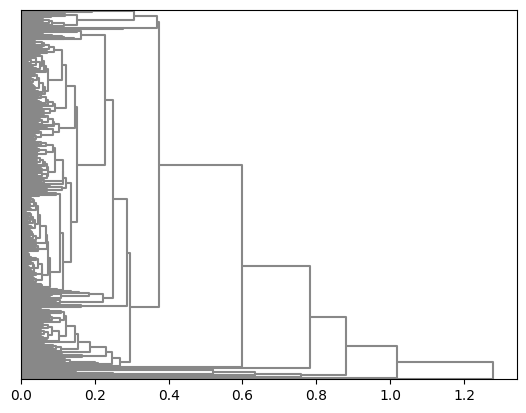

In [357]:
model = cluster.AgglomerativeClustering(linkage="average", distance_threshold=0, n_clusters=None).fit(Xn6v)
plot_dendrogram(model, orientation='right', truncate_mode="level", p=100, no_labels=True)

For the last 3 clusters:

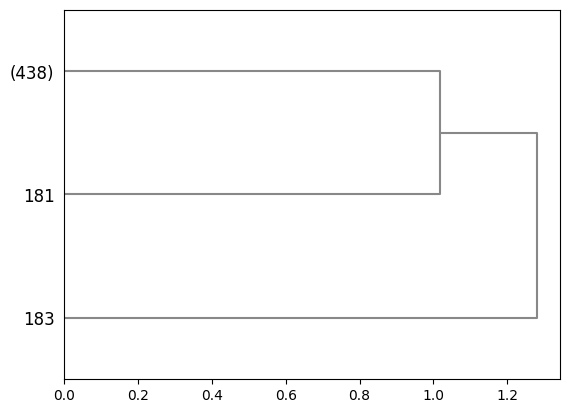

In [358]:
plot_dendrogram(model, orientation='right', truncate_mode="lastp", p=3)

And when we plot the clusters, we obtain the following:

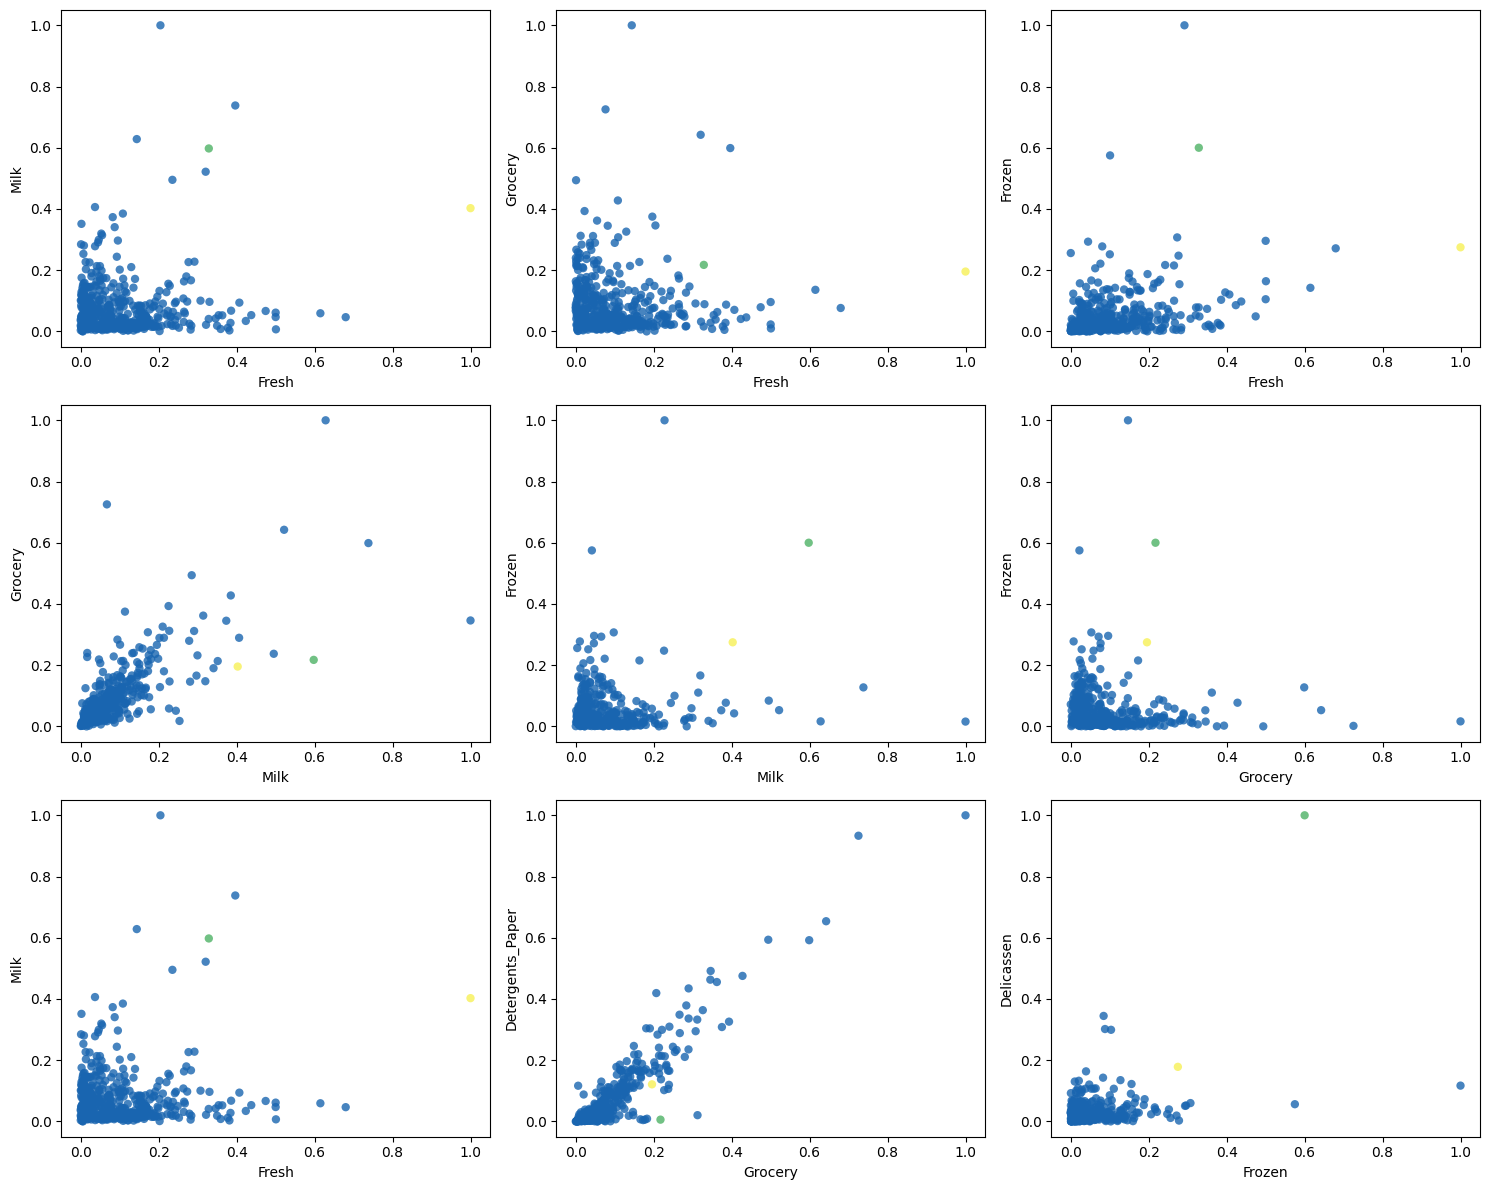

In [359]:
clAAn6v8 = cluster.AgglomerativeClustering(linkage="average", n_clusters=3).fit(Xn6v)
clAAn6v8_labels, map_labels = relabel_clusters_size(clAAn6v8.labels_)

plot_data(Xn6v, vnames6v, vpairs6v, clAAn6v8_labels)

Similar to the other agglomerative methods, most data points are in the same cluster:

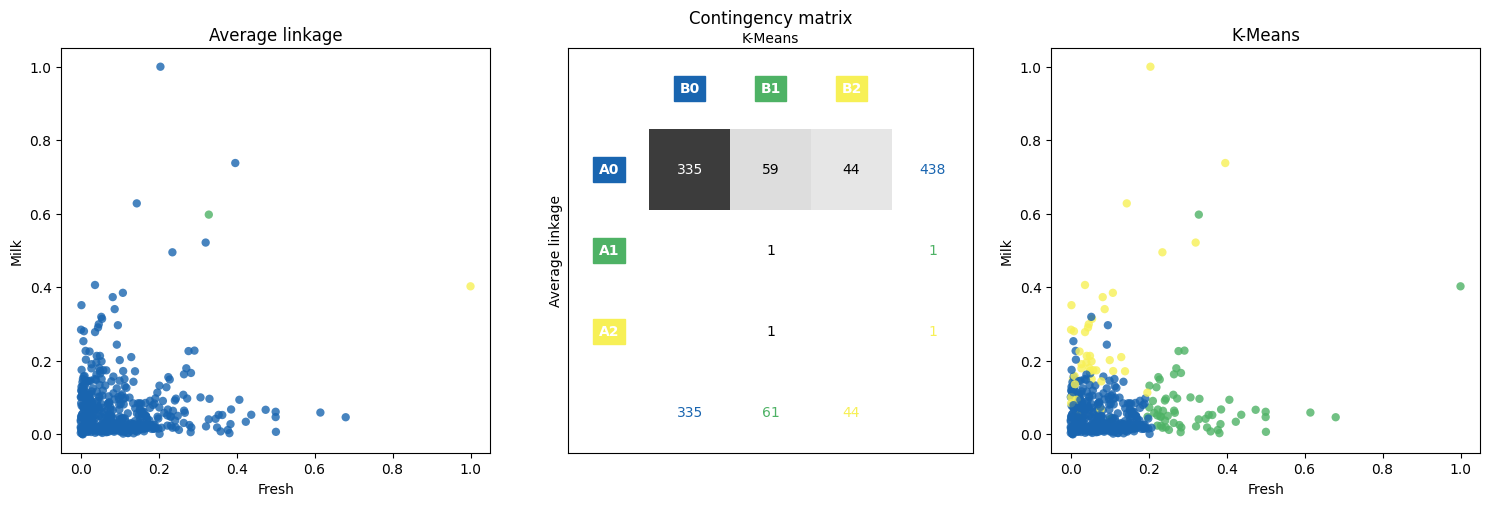

In [360]:
plot_contingency_matrix(clAAn6v8_labels, clKMn6v8_labels, "Average linkage", "K-Means", Xn6v, vnames6v, vps["Fresh-Milk"])

The rand and NMIS scores are:

In [361]:
metrics.rand_score(clAAn6v8_labels, clKMn6v8_labels), metrics.normalized_mutual_info_score(clAAn6v8_labels, clKMn6v8_labels)

(0.6146200041416442, 0.024319039693138807)

### Ward linkage

For _ward linkage_, we obtain the following dendogram:

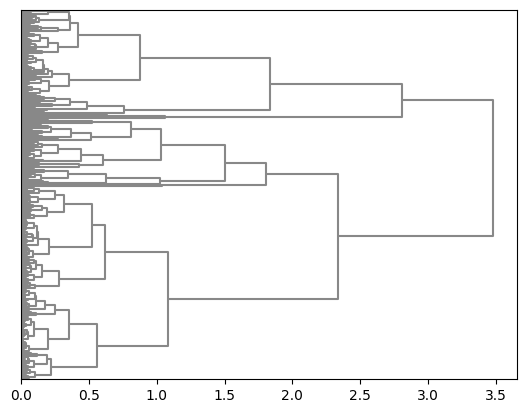

In [362]:
model = cluster.AgglomerativeClustering(linkage="ward", distance_threshold=0, n_clusters=None).fit(Xn6v)
plot_dendrogram(model, orientation='right', truncate_mode="level", p=100, no_labels=True)

And the last 8 clusters:

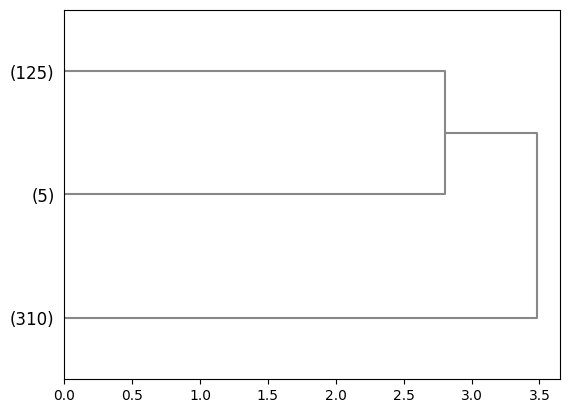

In [363]:
plot_dendrogram(model, orientation='right', truncate_mode="lastp", p=3)

Plotting the clusters, we obtain the following:

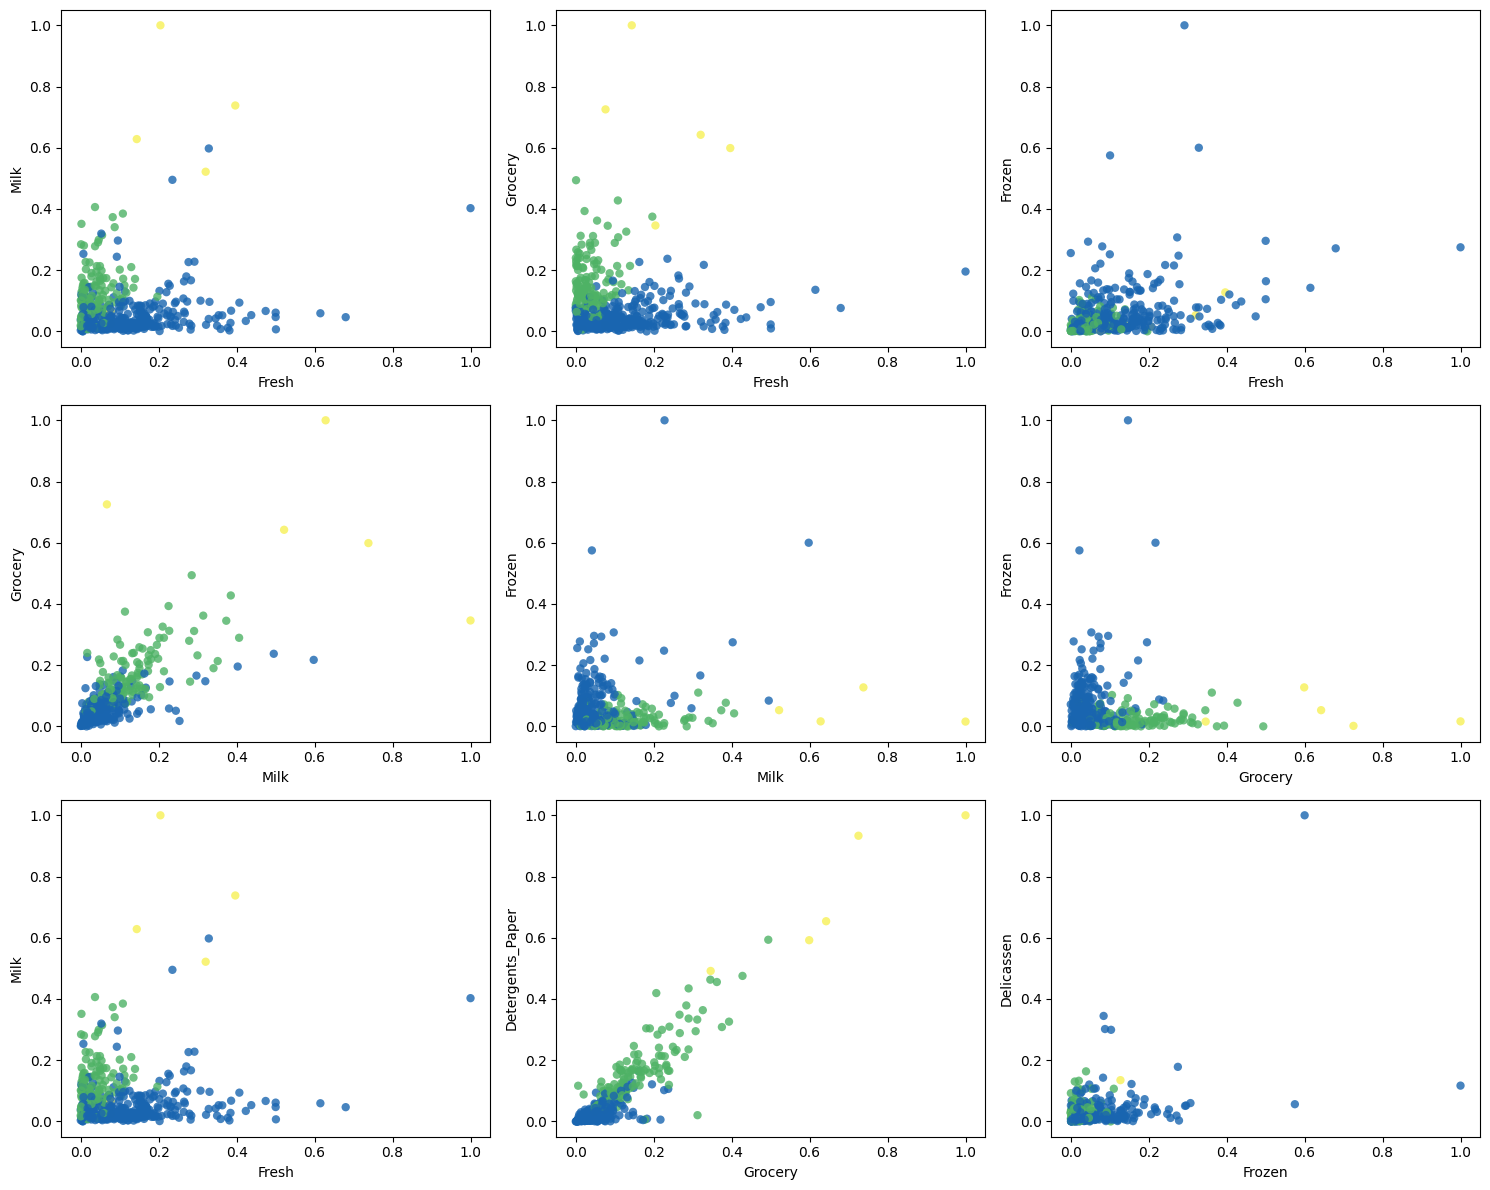

In [364]:
clAWn6v8 = cluster.AgglomerativeClustering(linkage="ward", n_clusters=3).fit(Xn6v)
clAWn6v8_labels, map_labels = relabel_clusters_size(clAWn6v8.labels_)

plot_data(Xn6v, vnames6v, vpairs6v, clAWn6v8_labels)

Finally, an agglomerative method that doesn't put all datapoints into a single cluster! Let's check the contingency matrix.

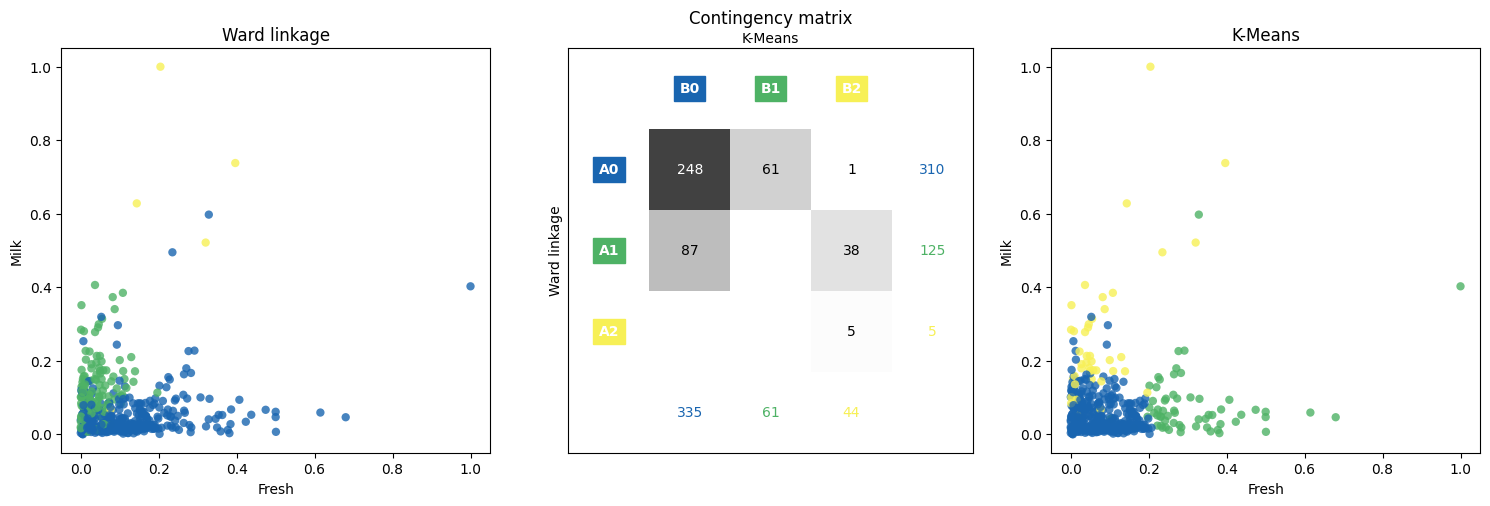

In [365]:
plot_contingency_matrix(clAWn6v8_labels, clKMn6v8_labels, "Ward linkage", "K-Means", Xn6v, vnames6v, vps["Fresh-Milk"])

Although _ward linkage_ basically ignored the third cluster, we can see that clusters `A0` and `A1` largely agree with `B0` and `B2`.

The rand score and NMIS are:

In [366]:
metrics.rand_score(clAWn6v8_labels, clKMn6v8_labels), metrics.normalized_mutual_info_score(clAWn6v8_labels, clKMn6v8_labels)

(0.58012010768275, 0.25325626187918604)

As expected, the values are much higher than when compared with what was obtained in other agglomerative methods, although still very low overall.

## DBSCAN

Now for the density based method, DBSCAN.

Since in many of the pairs, the datapoints are very densily accumulated in the bottom-left of the plots, it's expected that DBSCAN will consider most of them core points, while the few that are away from the big corner group will likely be considered noise points. Let's check this theory by applying the algorithm to our dataset.

In [367]:
clDBSn6v = cluster.DBSCAN(eps=0.1, min_samples=4).fit(Xn6v)
clDBSn6v_labels, map_labels = relabel_clusters_size(clDBSn6v.labels_)
numpy.bincount(clDBSn6v_labels+1)

array([ 40, 400], dtype=int64)

Checking the bin count, we can already see a problem: `40 noise points`, and only `1 cluster` with `400 points`. Let's plot these results.

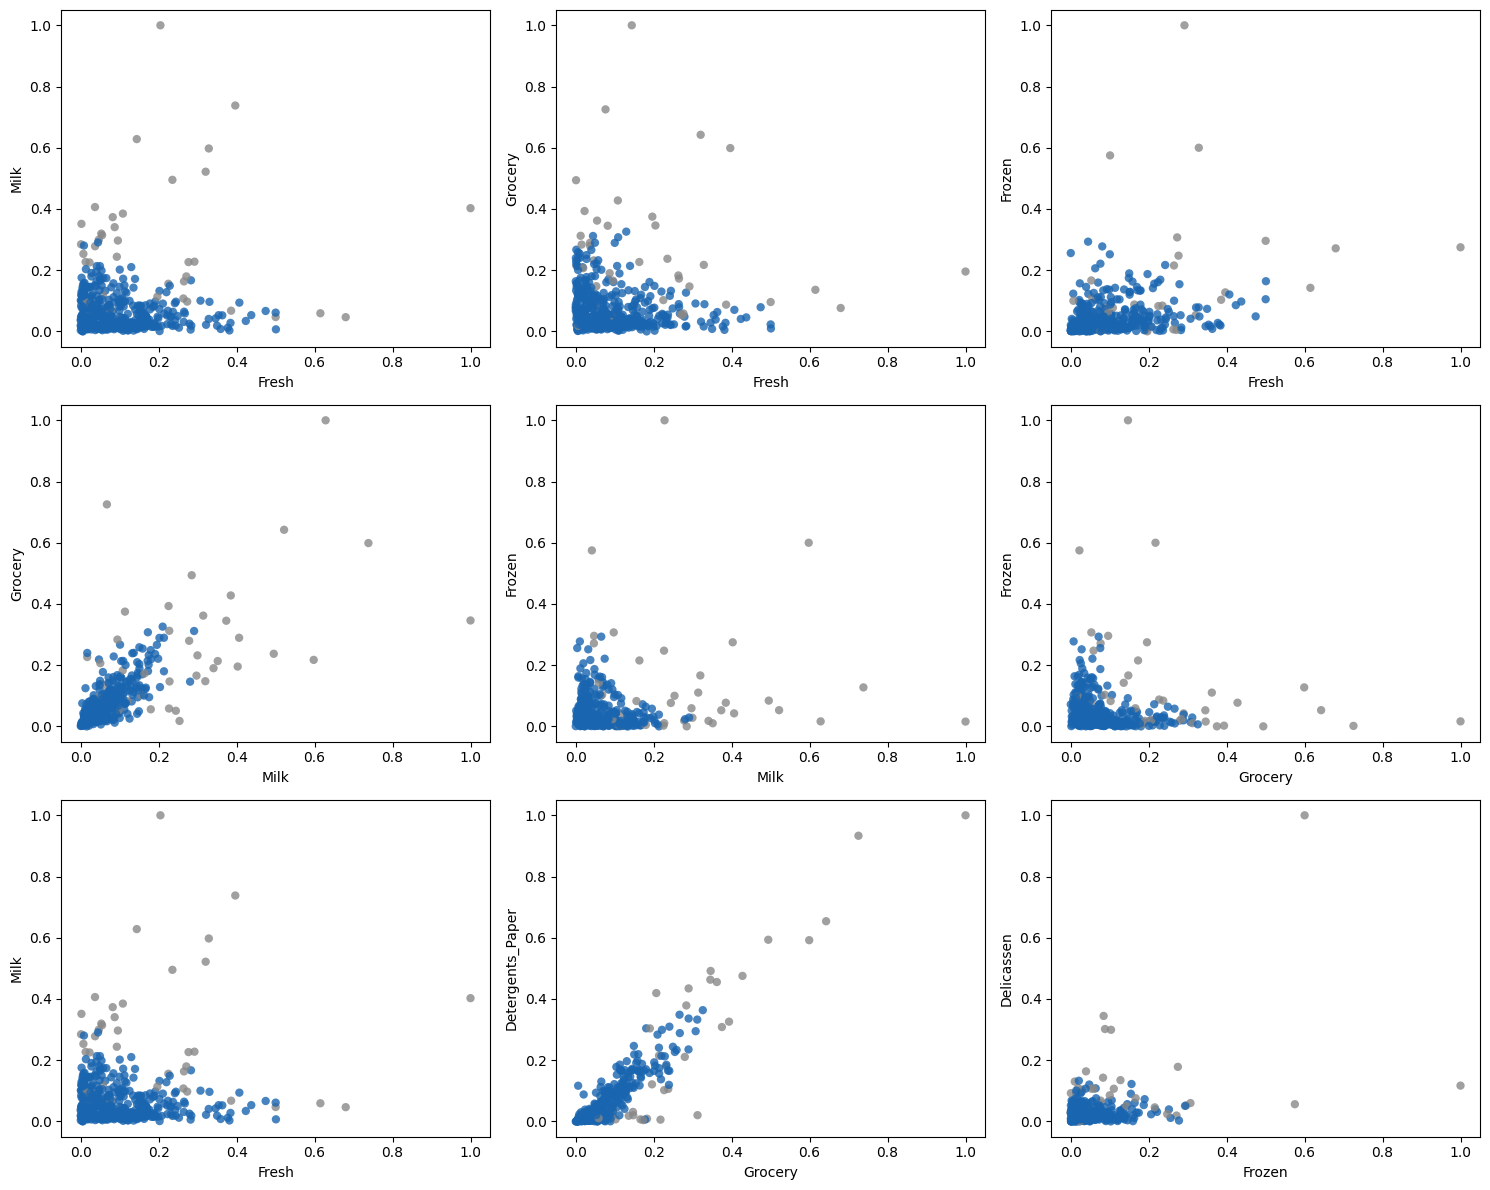

In [368]:
plot_data(Xn6v, vnames6v, vpairs6v, clDBSn6v_labels)

We could compare the clustering obtained here with the ones from the agglomerative methods, but we already know that there, most of them resulted in a single big cluster, which will result in a high value of agreement with DBSCAN, except for _ward linkage_. A more noteworthy analysis can be done by adjusting the parameters for the DBSCAN algorithm: $\epsilon$ and `min_samples`.

Since we know that most datapoints are heavily accumulated in a single spot of the plot, let's adjust $\epsilon$ to be much smaller, and increase `min_samples` so that we obtain very highly dense clusters. We'll try the following values:

- $\epsilon = 0.05$
- `min_samples` $= 12$

In [369]:
clDBSn6v = cluster.DBSCAN(eps=0.05, min_samples=12).fit(Xn6v)
clDBSn6v_labels, map_labels = relabel_clusters_size(clDBSn6v.labels_)
numpy.bincount(clDBSn6v_labels+1)

array([222, 194,  24], dtype=int64)

We obtained 2 clusters: one very large, and one small. Most datapoints are considered noise points. Plotting the clusters, we obtain the following:

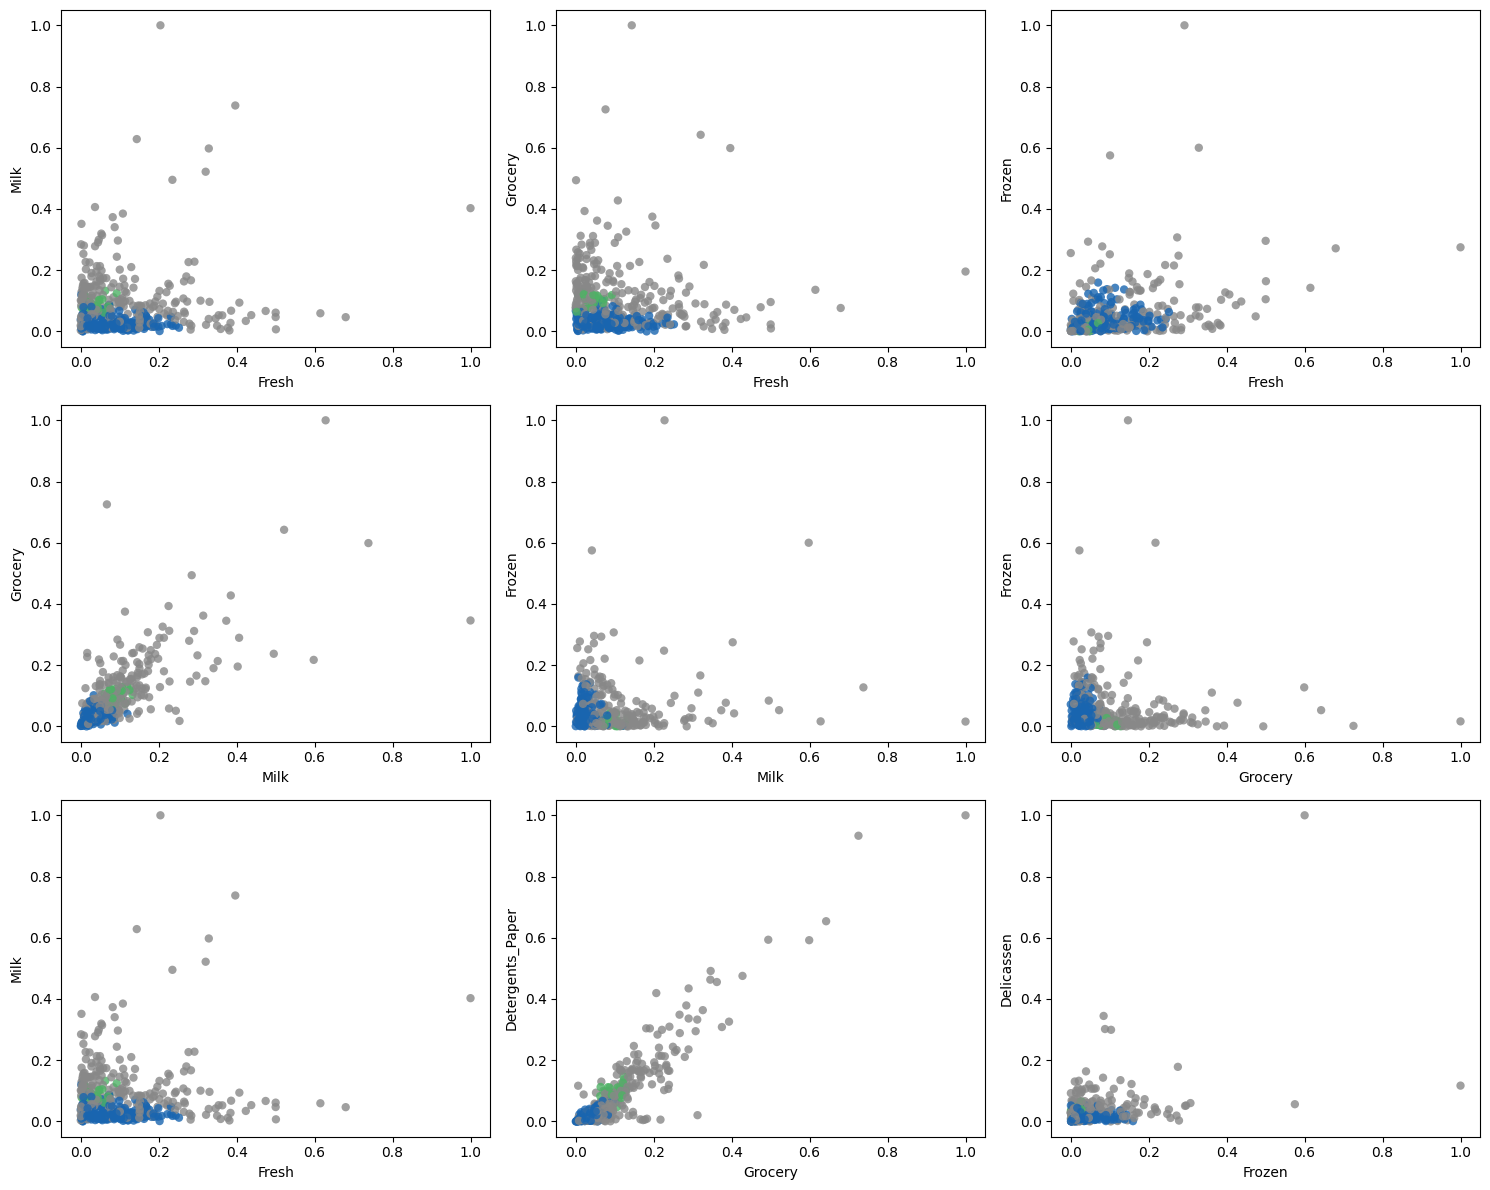

In [370]:
plot_data(Xn6v, vnames6v, vpairs6v, clDBSn6v_labels)

As I tuned the parameters, I concluded that DBSCAN is not a good method for clustering when all datapoints are agglomerated, as is the case for this dataset. The result will either be a single cluster with most data points, or 2-3 clusters with most data points being noise points.

Out of curiosity, we can plot the contingency matrix:

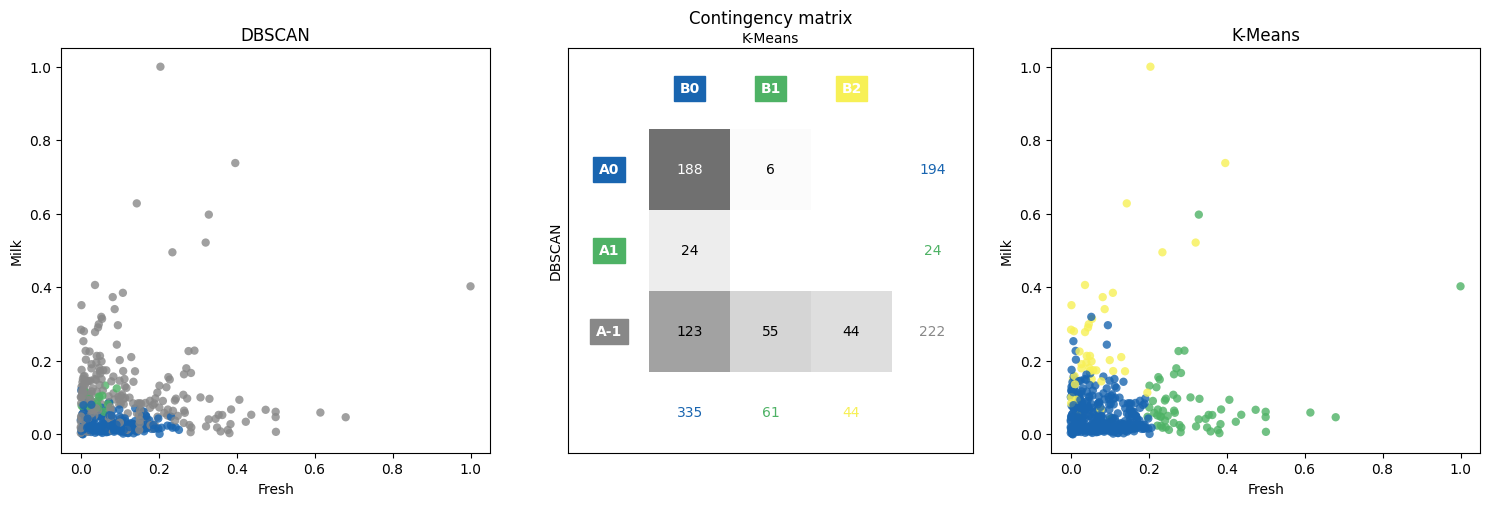

In [371]:
plot_contingency_matrix(clDBSn6v_labels, clKMn6v8_labels, "DBSCAN", "K-Means", Xn6v, vnames6v, vps["Fresh-Milk"])

At least clusters `A0` and `B0` largely agree. Let's also check the rand and NMIS scores:

In [372]:
metrics.rand_score(clDBSn6v_labels, clKMn6v8_labels), metrics.normalized_mutual_info_score(clDBSn6v_labels, clKMn6v8_labels)

(0.517053220128391, 0.18978218952937775)

Interestingly enough, rand score is quite decent, although NMIS is very low. A similar result was obtained in the `Beans` dataset, with `rand = 0.6927` and `NMIS = 0.4274`, but for $\epsilon = 0.1$ and `min_samples` $= 4$.

# Evaluation

Now it's time for the comparative evaluation.

In [381]:
v_dist6v = distance.pdist(Xn6v)

evl_series = [("KMeans (4)", clKMn6v4_labels),
              ("KMeans (3)", clKMn6v8_labels),
              ("Bisec.KMeans", clBKMn6v8_labels),
              ("Agg.Complete", clACn6v8_labels), 
              ("Agg.Single", clASn6v8_labels),  
              ("Agg.Ward", clAWn6v8_labels),  
              ("Agg.Average", clAAn6v8_labels), 
              ("DBSCAN", clDBSn6v_labels)
             ]
evl_stats = [[mname, numpy.max(clbls)+1, -1 in clbls, 
                 metrics.silhouette_score(Xn6v, clbls), intra_inter_distance_ratio(v_dist6v, clbls)]
                for (mname, clbls) in evl_series]
internal_df = pandas.DataFrame(columns=["name", "nb_clusters", "outliers", "silhouette", "distance ratio"],
                             data = evl_stats)
internal_df.sort_values(by=["distance ratio"])

,name,nb_clusters,outliers,silhouette,distance ratio
4,Agg.Single,3,False,0.791186,0.181970
6,Agg.Average,3,False,0.747367,0.216074
3,Agg.Complete,3,False,0.727341,0.242348
0,KMeans (4),4,False,0.411948,0.375646
1,KMeans (3),3,False,0.439756,0.385949
2,Bisec.KMeans,3,False,0.200654,0.538405
5,Agg.Ward,3,False,0.323499,0.582081
7,DBSCAN,2,True,0.009925,0.603654


Straight away we can notice two things: 

- the top method, `Agg.Single`, has the lowest distance ratio, indicating that the clusters are very cohesive, and also has the highest silhouette score, indicating that clusters are well apart from each other and clearly distinguished. These metrics are excellent, as long as we forget that `Agg. Single` clustered most data points into a single cluster, and the other 7 clusters have a single data points for, e.g., `Fresh-Milk`. In fact, the top 3 are the agglomerative methods that considered most data points in a single cluster. _Ward linkage_ was positioned lower in the table, as it was the one agglomerative method that didn't cluster moster datapoints into a single cluster.
- the 'worst' method, `DBSCAN`, has the highest distance ratio, indicating low cohesiveness between clusters, and also a silhouette score very close to 0, indicating that the clusters are indifferent, or, in other words, that the distance between clusters is insignificant. Also, `DBSCAN` is the only method with just 2 clusters.

Let's continue the analysis using the categorical labels as ground truth.


In [382]:
classes = dtf.values[:, 1]
map_classes = dict([(cn[1], ci) for ci, cn in enumerate(sorted([(numpy.sum(classes==c), c) for c in numpy.unique(classes)]))])
num_classes = numpy.array([map_classes[c] for c in classes], dtype=int)
gt_labels, map_labels = relabel_clusters_size(num_classes)

We can plot the ground truth to check the clusterings.

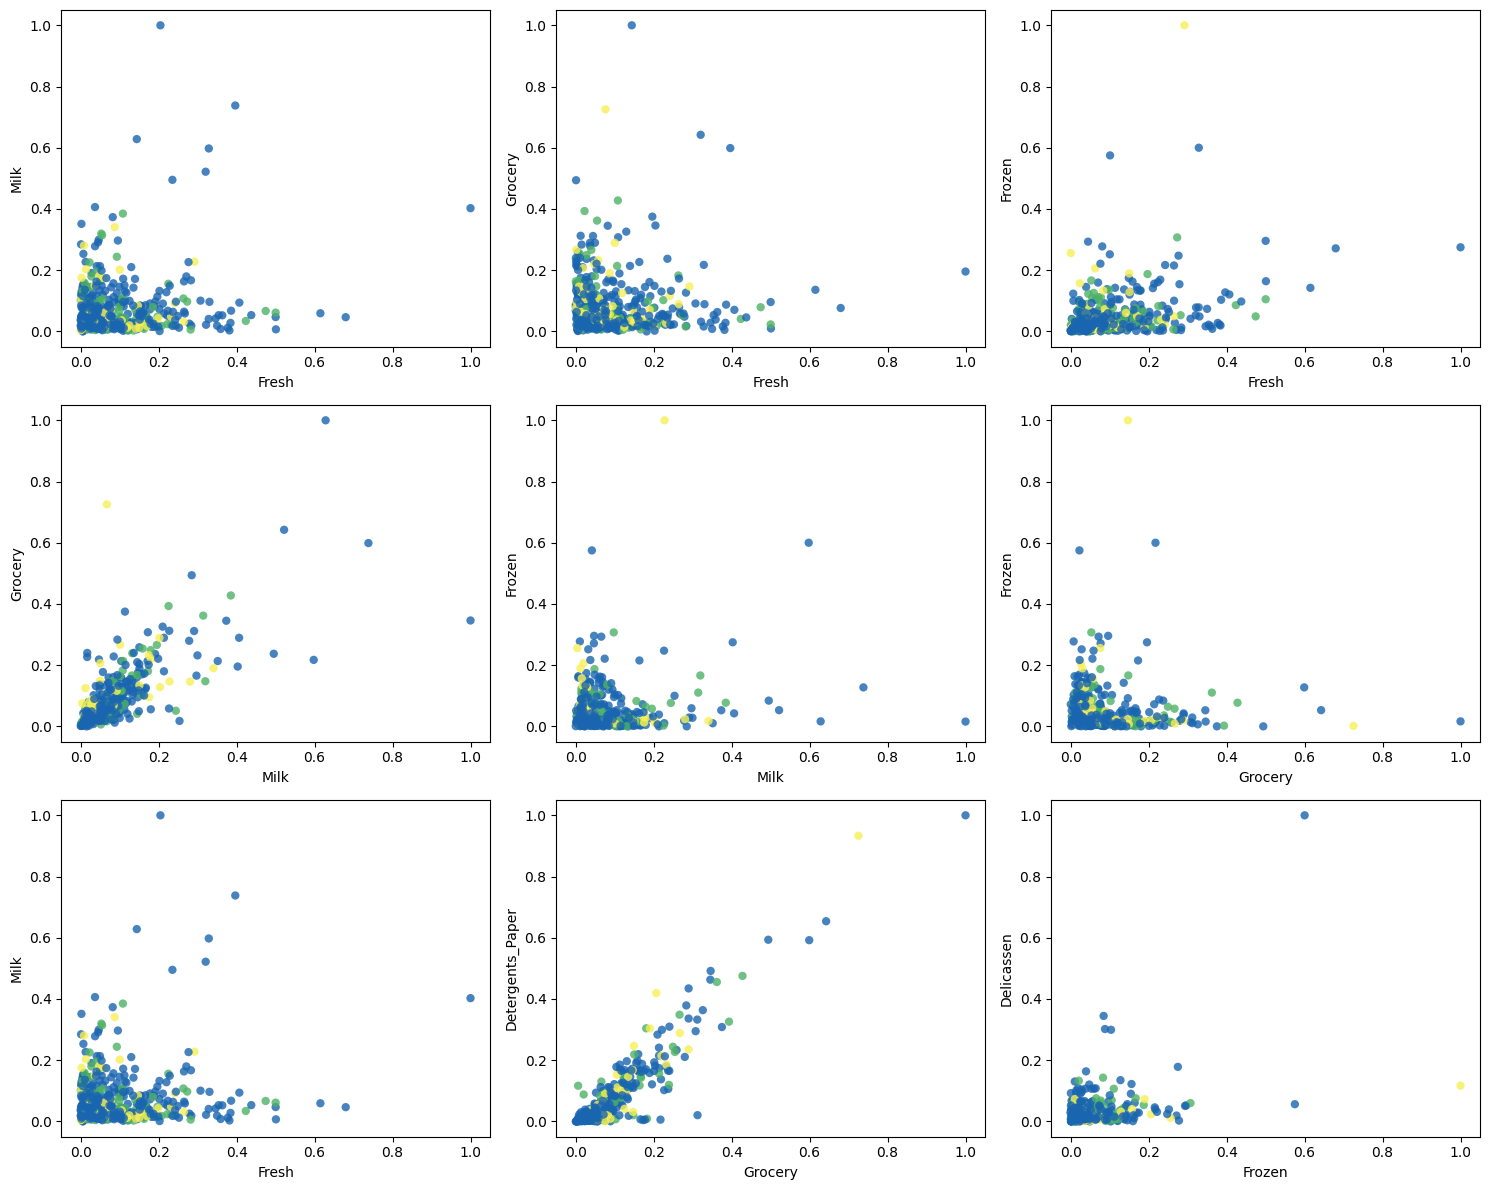

In [383]:
plot_data(Xn6v, vnames6v, vpairs6v, gt_labels)

It's noticeable that the clusterings overlap significantly.

Now, we compare the clustering to the partition corresponding to these class labels.

In [384]:
evl_stats = [[mname, numpy.max(clbls)+1, -1 in clbls, metrics.normalized_mutual_info_score(num_classes, clbls), metrics.rand_score(num_classes, clbls)] \
             for (mname, clbls) in evl_series]
external_df = pandas.DataFrame(columns=["name", "nb_clusters", "outliers", "rand score", "NMI"],\
                               data = evl_stats)
external_df.sort_values(by=["NMI"], ascending=False)

,name,nb_clusters,outliers,rand score,NMI
4,Agg.Single,3,False,0.003708,0.552868
6,Agg.Average,3,False,0.003708,0.552868
3,Agg.Complete,3,False,0.001771,0.550549
1,KMeans (3),3,False,0.005547,0.510934
5,Agg.Ward,3,False,0.003619,0.510561
7,DBSCAN,2,True,0.006074,0.496511
2,Bisec.KMeans,3,False,0.003376,0.494409
0,KMeans (4),4,False,0.002663,0.492048


From this table alone, we can see that the resulting clustering from the algorithms has terrible scores when compared with the ground truth. The highest value for rand score is `0.0060`, and for NMI it's `0.5528`. While the NMI values might be considered average, the rand score are essentially zero.

The final conclusion is that clustering for this dataset does not work due to the dataset characteristics: the ground truth clusters overlap, and the datapoints are mostly stacked.

No collaborations.

External resources: 
- https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c